# Variety of NA-MD methods in Libra


## Table of Content: <a name="TOC"></a>

1. [Generic setups](#1)

2. [Theoretical Background](#2)

   2.1. [Ehrenfest method](#2.1)
   
   2.2. [Mean Field with Stochastic Decoherence (MFSD)](#2.2)
   
   2.3. [Tully's Fewest Switches Surface Hopping (FSSH)](#2.3)
   
   2.4. [Global Flux Surface Hopping (GFSH)](#2.4)
   
   2.5. [Markov State Surface Hopping (MSSH)](#2.5)
   
   2.6. [Branching-Corrected Surface Hopping (BCSH)](#2.6)
   
   2.7. [Instantaneous Decoherence at Attempted hops (ID-A)](#2.7)
   
   2.8. [Simplified Decay of Mixing method (SDM)](#2.8)
   
   2.9. [Shenvi-Subotnik-Yang (SSY) corrected-methods](#2.9)
   
   2.10. [Decoherence-Induced Surface Hopping (DISH)](#2.10)

   2.11. [Surface Hopping based on eXact Factorization(SHXF)](#2.11)

   2.12. [Notes](#2.12)

3. [Model Hamiltonians](#3)

4. [Choosing the Nonadiabatic Dynamics Methodology](#4)

5. [Choosing initial conditions: Nuclear and Electronic](#5)

6. [Running the calculations](#6)

7. [Plotting the results](#7)



## A. Learning objectives

- to know the conceptual ideas (algorithms and some key equations) of various NA-MD methods available in Libra
- to be able to setup such NA-MD calculations with model Hamiltonians
- to be able to plot diabatic and adiabatic surfaces and NACs along the nuclear coordinate for model Hamiltonians
- to be able to setup initial conditions for electronic and nuclear degrees of freedom
- to be able to plot the key results of NA-MD simulations


## B. Use cases

- [Plot 1D PES](#)


## C. Functions

- `libra_py`
  - `dynamics_plotting`
    - [`plot_surfaces`](#plot_surfaces-1) 
  - `dynamics`
    - `tsh`
      - `compute`
        - [`generic_recipe`](#generic_recipe-1)
      - `plot`
        - [`plot_dynamics`](#plot_dynamics-1)        
  - `models`     
     - `Esch_Levine`
       - [`JCP_2020`](#Esch_Levine_JCP_2020-1)
     - `Holstein`
       - [`Holstein2`](#Holstein2-1)
     - `Morse`
       - [`general`](#Morse_general-1)
       - [`set_Coronado_Xing_Miller_params`](#set_Coronado_Xing_Miller_params-1)
       
       

## D. Classes and class members
    


## 1. Generic setups
<a name="1"></a>[Back to TOC](#TOC)

Here, we import all necessary libraries, set up some definitions (e.g. colors), and define the function that would be calling model Hamiltonians also defined within Libra package.

Note the section which imports recipes:

    from recipes import ehrenfest_adi_nac, ehrenfest_adi_ld, ehrenfest_dia
    from recipes import fssh, fssh_ssy, gfsh, gfsh_ssy, mssh, mssh_ssy, bcsh, bcsh_ssy
    from recipes import ida, ida_ssy, sdm, sdm_ssy
    from recipes import dish
    from recipes import mfsd
    from recipes import shxf


These recipes are nothing but various combinations of parameters, chosen to represent particular known method.

Of course, one can consider other, less standard combinations and define new recipes. 


In [1]:
import sys
import cmath
import math
import os
import h5py
import matplotlib.pyplot as plt   # plots
import numpy as np
import time
import warnings

from liblibra_core import *
import util.libutil as comn
from libra_py import units
import libra_py.models.Holstein as Holstein
import libra_py.models.Morse as Morse
import libra_py.models.Zhu as Zhu
import libra_py.models.Esch_Levine as Esch_Levine
from libra_py import dynamics_plotting
import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot
import libra_py.data_savers as data_savers


from recipes import ehrenfest_adi_nac, ehrenfest_adi_ld, ehrenfest_dia
from recipes import fssh, fssh_ssy, gfsh, gfsh_ssy, mssh, mssh_ssy, bcsh, bcsh_ssy
from recipes import ida, ida_ssy, sdm, sdm_ssy
from recipes import dish
from recipes import mfsd
from recipes import shxf

#from matplotlib.mlab import griddata
#%matplotlib inline 
warnings.filterwarnings('ignore')

colors = {}
colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   
colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      
colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  
colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/dhhan/conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/dhhan/conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/dhhan/conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::allocator<float> >

As a hint for an inpatient user who wants to get the calculations going on as soon as possible, you can simply look for sections that look like this:

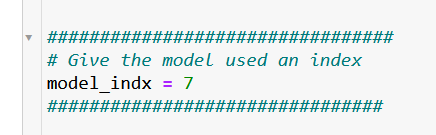

check the list of options and select the one that you want. Keep in mind that the list of the options available may be below the line where you'd need to select the option.

## 2. Theoretical Background
<a name="2"></a>[Back to TOC](#TOC)

The methods covered by these recipes include:

### 2.1. Ehrenfest method 
<a name="2.1"></a>[Back to TOC](#TOC)

* `ehrenfest_adi_nac` - this is Ehrenfest dynamics propagated in the adiabatic representation using vibronic Hamiltonian (and hence involving NACs explicitly). The problem with this approach is that NACs are usually affected by phase insconsistencies and state reordering (trivial crossings), so they may be discontinuous and hence lead to erroneous results.

* `ehrenfest_adi_ld` - this is Ehrenfest dynamics, also propagated in the adiabatic representation, but the TD-SE integration is done using local diabatization (LD) approximation. This approach does not need NACs, only time-overlaps. This approach fixes possible issues with the state crossing and phase inconsistencies of the propagated amplitudes, but doesn't fix any problems with the NACs (but those aren't used anyways).

* `ehrenfest_dia` - this is Ehrenfest that is formulated in terms of diabatic properties only, including the computation of forces. The TD-SE integration is done in the diabatic basis, so there are no problems with trivial crossing and phase inconsistencies. This is the most robust way to do the Ehrenfest calculations. It also doesn't need NACs.


### 2.2. Mean Field with Stochastic Decoherence (MFSD)
<a name="2.2"></a>[Back to TOC](#TOC)

* `mfsd` - this is the mean field with stochastic decoherence of Bedard-Hearn and Schwartz: 

     Bedard-Hearn, M. J.; Larsen, R. E.; Schwartz, B. J. Mean-Field Dynamics with Stochastic Decoherence (MF-SD): A New Algorithm for Nonadiabatic Mixed Quantum/Classical Molecular-Dynamics Simulations with Nuclear-Induced Decoherence. *J. Chem. Phys.* **2005**, 123, 234106. https://doi.org/10.1063/1.2131056.
      
This method is essentially like Ehrenfest, but there is always a probability to collapse the coherent superposition to a pure state. The probabilitiy of such a collapse is given by the quantum amplitude of the state $|c_i|^2$ and by the decoherence time $\tau_k$ to collapse onto a particular state k. The decoherence time is given by 

$$\frac{1}{\tau_k} = \sqrt{ \sum_n{ \frac{ (F^n_{MF}(t) - F^n_k)^2 }{ 4 a_n  \hbar^2} }} $$

where $F^n_{MF}(t)$ is the n-th component of the mean-field force and $F_n^k$ is the n-th component of the adiabatic force on state k

In the recipe, this method is selected as follows:

The nuclei are propagated according to the Ehrenfest force, computed in adiabatic representation

    dyn_general.update( {"force_method":2, "rep_force":1} ) # for Ehrenfest in adiabatic rep

There is no hops will be taken:

    dyn_general.update({"tsh_method":-1 }) # adiabatic, no surface hopping
    
    
There is no also hop acceptance or velocity rescaling involved, in the normal TSH sense:

    dyn_general.update({"hop_acceptance_algo":0, "momenta_rescaling_algo":0 })  # accept all hops, don't rescale velocity 
    
However, wavefunction collapses are determined based on the possibility to rescale momenta in the direction of the mean-field derivative coupling. The momenta are also rescaled in that direction when the hops are successful.

The MFSD correction is turned on by the following line:

    dyn_general.update({ "decoherence_algo":4}) # mfsd
    
Finally, since the method rrequires decoherence times, the are computed in this way:

    dyn_general.update( { "decoherence_times_type":2, "schwartz_decoherence_inv_alpha":A } ) # Schwartz version 1 - only this option is possible for MFSD!

This option corresponds to the formula above.



### 2.3. Tully's Fewest Switches Surface Hopping (FSSH)
<a name="2.3"></a>[Back to TOC](#TOC)

* `fssh` - this is original Tully's FSSH approach:

     Tully, J. C. Molecular Dynamics with Electronic Transitions. *J. Chem. Phys.* **1990**, 93, 1061–1071. https://doi.org/10.1063/1.459170.

The hoppings between adiabatic states occur with the probability 

$$P_{i->j} = \frac{dt}{\hbar \rho_{ii} } Im( \rho_{ij} H_{vib,ji} - H_{vib,ij} \rho_{ji} )$$ 

This is derived in a following way. We start with the TD-SE eequation:
$$ \frac{dc}{dt} = -\frac{i}{\hbar} H_{vib} C $$ and hence 
$$ (\frac{dc}{dt})^+ = \frac{i}{\hbar} C^+  H_{vib}^+$$
$$\rho = C C^+$$
hence:
$$\frac{d\rho}{dt} = \frac{i}{\hbar} (\rho H_{vib} - H_{vib} \rho)$$

The diagonal element is:

$$\frac{d\rho_{ii}}{dt} = \frac{i}{\hbar} (\rho_{ia} H_{vib, ai} - H_{vib, ia} \rho_{ai})$$

Then the probability to leave state i is:  $$P(i \to *) = -\frac{d\rho_{ii}}{\rho_{ii}} dt$$

Then we can split the total flux out of state i to specific states as:  

$$P(i \to a) = -\frac{dt}{\rho_{ii}} Re( \frac{i}{\hbar}  ( \rho_{ia} H_{vib, ai} - H_{vib, ia} \rho_{ai} ) ) = 
\frac{dt}{\hbar \rho_{ii} } Im( \rho_{ia} H_{vib,ai} - H_{vib,ia} \rho_{ai} )$$
       
       
but the TD-SE is propagated coherently, despite the state change

The hops are forbidden if there is not enough kinetic energy in a specified direction (here, parallel to momenta, in the original FSSH - parallel to derivative couplings) to accommodate the corresponding change of the potential energy. 

If the hops are accepted - nuclear momenta are uniformly rescaled to conserve the total energy

If the hops are rejected (frustrated hops) - momenta are reversed (in this recipe)

In recipe, this method is selected by:

    dyn_general.update({"tsh_method":0 }) # FSSH
    
also, the recipe ensures tha no any decoherence corrections is added on top:

    dyn_general.update({ "decoherence_algo":-1}) # no (additional) decoherence
    

### 2.4. Global Flux Surface Hopping (GFSH)
<a name="2.4"></a>[Back to TOC](#TOC)

* `gfsh` recipe is largely analogous to the FSSH, except it redefines the hopping probabilities as:

$$P(i \to j) = \frac{ \Delta \rho_{ii} }{\rho_{ii}} \frac{ \Delta \rho_{jj} }{ \sum_{k \in A}{\Delta \rho_{kk}}} i\in A, j\in B$$
The method is defined in: Wang, L.; Trivedi, D.; Prezhdo, O. V. Global Flux Surface Hopping Approach for Mixed Quantum-Classical Dynamics. *J. Chem. Theory Comput.* **2014**, 10, 3598–3605. https://doi.org/10.1021/ct5003835.


Here, before the hopping probability is computed, all states are classified into two groups: group A - are the states whose quantum populations decreased and group B - those whose quantum population increased. 

In recipe, this method is selected by:

    dyn_general.update({"tsh_method":1 }) # GFSH

also, the recipe ensures tha no any decoherence corrections is added on top:

    dyn_general.update({ "decoherence_algo":-1}) # no (additional) decoherence


### 2.5. Markov State Surface Hopping (MSSH)
<a name="2.5"></a>[Back to TOC](#TOC)
* `mssh` - This is a pretty naive and simplistic approach described in:

  Akimov, A. V.; Trivedi, D.; Wang, L.; Prezhdo, O. V. Analysis of the Trajectory Surface Hopping Method from the Markov State Model Perspective. *J. Phys. Soc. Jpn.* **2015**, 84, 094002. https://doi.org/10.7566/JPSJ.84.094002. 
    
although could actually be traced back to pre-FSSH times and could also be named "frequent switches surface hopping".

In this approach, the hopping to a state i is attepted with the probability proportional to its quantum probability $|c_i|^2$ that is:

$$P(current \to i) = |c_i(t)|^2$$

In recipe, it is selected by:

    dyn_general.update({"tsh_method":2 }) # MSSH
    
also, the recipe ensures tha no any decoherence corrections is added on top:

    dyn_general.update({ "decoherence_algo":-1}) # no (additional) decoherence
        

### 2.6. Branching-Corrected Surface Hopping (BCSH)
<a name="2.6"></a>[Back to TOC](#TOC)
* `bcsh` - This is one of the simplest and parameter-free ways of including decoherence effects in the surface hopping algorithms, described in:

  Xu, J.; Wang, L. Branching Corrected Surface Hopping: Resetting Wavefunction Coefficients Based on Judgement of Wave Packet Reflection. *J. Chem. Phys.* **2019**, 150, 164101. https://doi.org/10.1063/1.5090927.


In this approach, decoherence correction is interpreted as a way to enforce the self-consistency of the TD-SE with the quantum-classical trajectories rather than as a common view of a decay of overlap of wavepackets moving on different PE surfaces. Namely:
 - at every nonadiabatic interaction region, there is a possibility of the wavepacket branching into reflecting and transmitting wavepackets on different surfaces. 
 - the idea is to eliminate the wavepackets that go in the opposite direction with the main wavepacket on the active state. 
 - the correction is applied only at the reflection points (not the reflection of active trajectory, but the reflection of the wavepacket on other surfaces in comparison to that of the active surface)
 - the reflection is judged as:

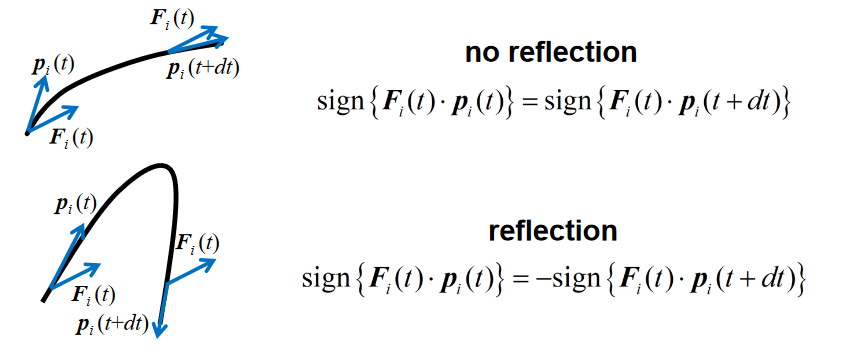
 [see here for more details](https://quantum-dynamics-hub.github.io/VISTA/assets/presentations/seminar1/LinjunWang.pdf)

 - if the reflection is determined for the wavepacket on the active state, the superposition collapses on this state;
 - if the reflection is determined for the wavepacket on the non-active state, this wavepacket is projected out (it's amplitude is set to zero) and the rest of the amplitudes is rescaled to ensure norm conservation
 
In recipe, the BCSH is selected by:

    dyn_general.update({ "decoherence_algo":3}) # BCSH
    
It doesn't need any decoherence time parameters, so:

    dyn_general.update({"decoherence_times_type":-1 }) # No decoherence times, infinite decoherence times

also note that it is used with the FSSH hopping algorithm:

    dyn_general.update({"tsh_method":0 }) # FSSH
    
in principle, it could be used with other hopping algorithms.


 
### 2.7. Instantaneous Decoherence at Attempted hops (ID-A)
 <a name="2.7"></a>[Back to TOC](#TOC)
 * `ida` recipe is yet another simple and parameters-free decoherence correction approach described in:
   Nelson, T.; Fernandez-Alberti, S.; Roitberg, A. E.; Tretiak, S. Nonadiabatic Excited-State Molecular Dynamics: Treatment of Electronic Decoherence. *J. Chem. Phys.* **2013**, 138, 224111. https://doi.org/10.1063/1.4809568.

The idea of the method is to enforce the consistency of active states changes in the surface hopping procedure and the corresponding coherent (TD-SE) wavefunctions. This is done by collapsing the TD-SE superposition to the active state at every attempted hops (hence, ID-A). These is also an option to do such a collapse only at every successful hop (ID-S), but it was demonstrated to be inferior to the ID-A variant

 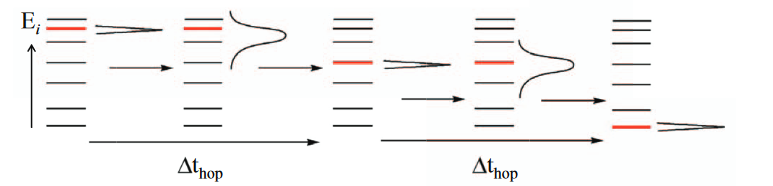
 
In the recipe, this option is selected by

    dyn_general.update({ "decoherence_algo":1}) # IDA    
    
together with

    dyn_general.update({"decoherence_times_type":-1 }) # No decoherence times, infinite decoherence times


Although the recipe doesn't state this explicitly, the reason why `"decoherence_algo":1` selects ID-A and not ID-S
is because the default parameter `"instantaneous_decoherence_variant":1` (for ID-A) is used. If you want to run ID-S calculations, add this instruction:

    dyn_general.update({ "instantaneous_decoherence_variant":0 }) # ID-S


### 2.8. Simplified Decay of Mixing method (SDM)
 <a name="2.8"></a>[Back to TOC](#TOC)
 
* `sdm` - this is the simplified decay of mixing approach of Granucci and Persico described in:
  Granucci, G.; Persico, M. Critical Appraisal of the Fewest Switches Algorithm for Surface Hopping. *J. Chem. Phys.* **2007**, 126, 134114. https://doi.org/10.1063/1.2715585.

The approach largely follows that of the FSSH with the only exception that coherently-propagated TD-SE amplitudes are dampened with characteristic timescales:

$$C'_j(t) = C_j(t) exp(-\Delta t / \tau_{ji}), j \neq i$$

and

$$C'_i(t) = C_i(t) \sqrt{ \frac{1 - \sum_{j \neq i}{|C'_j|^2} } { |C_i|^2 } } $$

Here, the decoherence time $\tau_{ij}$ is computed according to energy-based decoherece scheme:

$$\tau_{ij} = \frac{\hbar}{|E_i - E_j|} (C + \frac{\epsilon}{E_{kin}})  $$

Here, $E_i$ is the energy of i-th adiabatic state, $E_{kin}$ is the kinetic energy,  $C = 1.0$ and $\epsilon = 0.1 Ha$ an empirical parameter

In the recipe, this method is selected as follows:

The hopping is taken as in FSSH:

    dyn_general.update({"tsh_method":0 }) # FSSH
    
The decoherence correction as given by the above formulas:

    dyn_general.update({ "decoherence_algo":0}) # msdm  
    
The decoherence time $\tau_{ij}$ is computed according to the energy-based decoherence formula:

    dyn_general.update( { "decoherence_times_type":1, "decoherence_C_param": 1.0, "decoherence_eps_param":0.1 } )  # EDC + default params
    
In principle, one could use alternative formulas for decoherence times, such as the one by Schwartz:

   Schwartz, B. J.; Bittner, E. R.; Prezhdo, O. V.; Rossky, P. J. Quantum Decoherence and the Isotope Effect in Condensed Phase Nonadiabatic Molecular Dynamics Simulations. *J. Chem. Phys.* **1996**, 104, 5942–5955. https://doi.org/10.1063/1.471326.

$$\frac{1}{\tau_{ij}} = \sqrt{ \sum_n{ \frac{ (F^n_i(t) - F^n_j)^2 }{ 4 a_n  \hbar^2} }} $$

This could be done with the following modification of the recipe:

    dyn_general.update( { "decoherence_times_type":3, "schwartz_decoherence_inv_alpha":A } ) # Schwartz version 2
                
Here, the parameter A would be the ndof x ndof matrix with the diagonal elements containing the width parameters for all `ndof` nuclear degrees of freedom $a_n$ 

### 2.9. Shenvi-Subotnik-Yang (SSY) corrected-methods
 <a name="2.9"></a>[Back to TOC](#TOC)
* `fssh_ssy`, `gfsh_ssy`, `mssh_ssy`, `bcsh_ssy`, `ida_ssy`, `sdm_ssy` - these the SSY-corrected FSSH, GFSH, MSSH, BCSH, IDA, and SDM algorithms, respectively. The correction is described in:
  Shenvi, N.; Subotnik, J. E.; Yang, W. Phase-Corrected Surface Hopping: Correcting the Phase Evolution of the Electronic Wavefunction. *J. Chem. Phys.* **2011**, 135, 024101. https://doi.org/10.1063/1.3603447.

The approach adds a phase difference accumulation that would be encountered by the wavepacket travelling on different surfaces, but that is not present in the over-coherent versions of the algorithms (e.g. original FSSH, etc.). 

$$H_{vib,ij}^n = -P_n^T M^{-1} P_i \delta_{ij} - i \hbar P_n^T M^{-1} D_{ij} $$

Here, n is the active state, $P_n$ is the ndof-dimensional vector of momenta on state n, $M^{-1}$ is the diagonal matrix of inverse masses for all nuclear degrees of freedom, $D_{ij}$ is the ndof-dimensional derivative couplings vector for a pair of states i and j.

The auxiliary momentum on every surface i, $P_i$, is computed as:

$$ P_i = sign(P_n) \sqrt{P_n^T P_n + 2 m (E_i - E_n) }, if P_n^T P_n + 2 m (E_i - E_n) > 0; P_i = 0 otherwise $$  

Although the original work of Shenvi, Subotnik, and Yang considered only a 2-state case, a generalization to multiple states appeared in a later work by Miao and Subotnik: Miao, G.; Subotnik, J. Revisiting the Recoherence Problem in the Fewest Switches Surface Hopping Algorithm. *J. Phys. Chem. A* **2019**, 123, 5428–5435. https://doi.org/10.1021/acs.jpca.9b03188.

The algorithm only modifies the coherent integration part, that is the propagation of the coefficients according to modified TD-SE. That's why the correction can be combined with any of the listed uncorrected methods.  

The corresponding `_ssy` recipes are created from the original recipes by adding:

    dyn_general.update({"do_ssy":1 }) # do no use it - that's the default
    
### 2.10. Decoherence-Induced Surface Hopping (DISH)
 <a name="2.10"></a>[Back to TOC](#TOC)
 
 * `dish` - this recipe defines the decoherence-induced surface hopping (DISH) method of Jaeger, Fisher and Prezhdo, as initially defined in:
   Jaeger, H. M.; Fischer, S.; Prezhdo, O. V. Decoherence-Induced Surface Hopping. *J. Chem. Phys.* **2012**, 137, 22A545. https://doi.org/10.1063/1.4757100.
   and later revised in
   Akimov, A. V. Excited State Dynamics in Monolayer Black Phosphorus Revisited: Accounting for Many-Body Effects. *J. Chem. Phys.* **2021**, 155, 134106. https://doi.org/10.1063/5.0065606.

Unlike in FSSH and alike procedures, the hopps between adiabatic states originate in this method as a result of decoherence. A brief workflow of this algorithm is as follows:

- The decoherence events are monitored; The time at which an arbitrary state i will experience a decoherence event is exponentially distributed with the corresponding decoherence time $\tau_i$ such that $\frac{1}{\tau_i} = \sum_j { \rho_{jj} \tau_{ij} }$. Here, $\tau_{ij}$ is a the dephasing time for a pair of states i and j.

- At the decoherence event, the coherent superposition can be collaped onto the decohered state i with the probability $|c_i|^2$  or the decohering state is projected out of the coherent superposition with the probability $1 - |c_i|^2$

- In the original prescription of Jaeger et al. one can encounter a situation that a currently-active state would become decoherent and could be projected out. In this case, one run into a problem of inconsistency of the surface hopping statistics of states with the quantum amplitudes. The revision of Akimov handles this situation: if the decohered state turns out to be the  active one, we project the corresponding amplitude out only if a successful hop to any other state can occur. The hop to any other state j is proposed with the probability $|c_j|^2$ and if the hop into this state is successful, the superposition is collaped onto this new state and the hop occurs.  

- Alternatively, if the decohered state j is not active, the stnadard procedure is applied: the hop into this state is proposed with the quantum probability $|c_j|$. IF the hop can be accepted, the wavefunction collapses onto this state, together with the surface hop. 

### 2.11. Surface Hopping based on eXact Factorization (SHXF)
<a name="2.11"></a>[Back to TOC](#TOC)

 * `shxf` - this recipe defines the decoherence-induced surface hopping based on XF (DISH-XF) or SHXF method of Ha and Min:
 
   Ha, J.-K.; Lee, I. S.; Min, S. K. Surface Hopping Dynamics beyond Nonadiabatic Couplings for Quantum Coherence. *J. Phys. Chem. Lett.* **2018**, 9, 1097. https://doi.org/10.1021/acs.jpclett.8b00060.

The approach is an indepdent-trajectory nonadiabatic dynamics method based on XF. While the nuclear propagation is simplified by following the conventional FSSH procedure, the electronic propagation follows the electronic part of the XF-based mixed quantum classical equation. The differential equation for adiabatic coefficients $C_{k}^{(I)}$ of the $I$th trajectory is given as

$$ \dot C^{(I)}_k(t) = -\frac{i}{\hbar}E^{(I)}_k(t)C^{(I)}_k(t)- \sum_j\sum_\nu{\bf d}^{(I)}_{kj\nu}(t)\cdot\dot{\bf R}^{(I)}_\nu(t)C^{(I)}_j(t) -\sum_j\sum_\nu\frac{\mathcal{P}_{\nu}(\mathbf{R}^{(I)},t)}{\hbar M_\nu} \cdot\left\{{\bf f}^{(I)}_{j\nu}(t)-{\bf f}^{(I)}_{k\nu}(t)\right\}|C^{(I)}_j(t)|^2 C^{(I)}_k(t) $$

The quantum momentum $\mathcal{P}_{\nu}=-\hbar \nabla_{\nu}|\chi|^{2}/2|\chi|^{2}$ is calculated by approximating each nuclear adibatic wavepacket to a Gaussian function.
$$ |\chi|^2 = \sum_{k}|\chi_{k}|^2 = \sum_{k}N_{k}\prod_\nu
         \exp\left(-\dfrac{|\textbf{R}^{(I)}_\nu-\textbf{R}_{k\nu}|^2}{2\sigma^2_{\nu}}\right). $$
The width of a Gaussian function is given by the `"wp_width"` parameter. Typically, the width parameter is determined according to the variance of nuclear distribution. As `"wp_width"` decreases, the effect of decoherence becomes more pronounced. Also, the position of each adiabatic wave packet, $\textbf{R}_{k\nu}$ is estimated by propagating state-wise auxiliary trajectories. Their evolutions are conducted by a uniform velocity motion from the energy conservation:

$$ \sum_{\nu}\frac{1}{2}M_{\nu}\dot{\mathbf{R}}_{k\nu}^{(I)2}(t)= \sum_{\nu}\frac{1}{2}M_{\nu}\dot{\mathbf{R}}_{\nu}^{(I)2}(t)+E^{(I)}(t)-E_{k}^{(I)}(t)$$

While auxiliary trajectories are propagated in the interval $[t_{0}, t]$, the spatial derivative of phase $\mathbf{f}_{k\nu}^{(I)}$ is computed by the change of momentum:
$$ \mathbf{f}_{k\nu}^{(I)}(t) = -\int_{t_{0}}^{t} \nabla_{\nu}E_{k}^{(I)}(\tau) d\tau \approx M_{\nu}\dot{\mathbf{R}}_{k\nu}^{(I)}(t) - M_{\nu}\dot{\mathbf{R}}_{k\nu}^{(I)}(t_{0}) $$

In recipe, the SHXF method is selected by

    dyn_general.update({"decoherence_algo":5 })

Its nuclear propagation follows the conventional FSSH procedure, thus 

    dyn_general.update({"tsh_method":0 })

### 12. Notes
<a name="2.12"></a>[Back to TOC](#TOC)

1. For the Ehrenfest and MFSD recipes, there is no adiabatic state change, so the populations of interest are those based on the wavefunction amplitudes $|c_i|^2$ 

2. For all surface hopping approaches, the momentum is rescaled uniformly and is reversed on the frustrated hops:

       dyn_general.update({"hop_acceptance_algo":10, "momenta_rescaling_algo":101 })  # accept and rescale based on total energy, reverse on frustrated
       
3. For all surface hopping methods, the TD-SE is integrated in adiabatic basis and the local diabatization approach is used:

       dyn_general.update({"rep_tdse":1, "electronic_integrator":2 })   # ld, original, with exp_
       
4. For all surface hopping methods, the state-resolved (adiabatic state) forces are used. The forces are computed using the adiabatic results directly:

       dyn_general.update( {"force_method":1, "rep_force":1} ) # state-resolved (e.g. TSH) with adiabatic forces

## 3. Model Hamiltonians
<a name="3"></a>[Back to TOC](#TOC)

First, let's define the `compute_model` function that returns all the necessary objects and properties for the dynamics. 
<a name="Holstein2-1"></a><a name="Esch_Levine_JCP_2020-1"></a><a name="Morse_general-1"></a>

In [2]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None
    
    if model==1:        
        res = Holstein.Holstein2(q, params, full_id) 
    elif model==2:
        res = Esch_Levine.JCP_2020(q, params, full_id)        
    elif model==3:
        res = Morse.general(q, params, full_id)
    else:
        pass #res = compute_model_nbra_files(q, params, full_id)            

    return res

Define several sets of parameters for Holstein Hamiltonian. 

Here, we define several sets of parameters:

* Sets 1 to 4 - for the 2-level Holstein Hamiltonians. These are just parabolas with constant coupling.
* Sets 5 to 8 - for the n-level Esch-Levine Hamiltonians. These are just lines or bundles of lines crossing with yet another line and having a constant coupling. These models are for 2- to 5-state problems
* Sets 9 to 11 - for the 3-level problems, which are the Morse potentials with non-constant coupling. The parameters are loaded to be those use by Coronado, Xing, and Miller. 

<a name="set_Coronado_Xing_Miller_params-1"></a>

In [3]:
model_params1 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0,  0.0], "x_n":[0.0,  2.5],"k_n":[0.002, 0.005],"V":0.000}
model_params2 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0,  0.0], "x_n":[0.0,  2.5],"k_n":[0.002, 0.005],"V":0.001}
model_params3 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0,  0.0], "x_n":[0.0,  2.5],"k_n":[0.002, 0.005],"V":0.01}
model_params4 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0, -0.01], "x_n":[0.0,  0.5],"k_n":[0.002, 0.008],"V":0.001}

model_params5 = {"model":2, "model0":2, "nstates":2, 
                 "w0":0.015, "w1":0.005, "V":0.005, "eps":0.0, "i_crit":2, "delta":0.01 } # Esch-Levine

model_params6 = {"model":2, "model0":2, "nstates":3, 
                 "w0":0.015, "w1":0.005, "V":0.005, "eps":0.0, "i_crit":3, "delta":0.01 } # Esch-Levine

model_params7 = {"model":2, "model0":2, "nstates":5, 
                 "w0":0.015, "w1":0.005, "V":0.005, "eps":0.0, "i_crit":4, "delta":0.01 } # Esch-Levine

model_params8 = {"model":2, "model0":2, "nstates":5, 
                 "w0":0.015, "w1":0.005, "V":0.005, "eps":0.02, "i_crit":3, "delta":0.01 } # Esch-Levine

model_params9 = {"model":3, "model0":3, "nstates":3}; Morse.set_Coronado_Xing_Miller_params(model_params9, 1)
model_params10 = {"model":3, "model0":3, "nstates":3}; Morse.set_Coronado_Xing_Miller_params(model_params10, 2)
model_params11 = {"model":3, "model0":3, "nstates":3}; Morse.set_Coronado_Xing_Miller_params(model_params11, 3)


all_model_params = [model_params1, model_params2, model_params3, model_params4, 
                    model_params5, model_params6, model_params7, model_params8,
                    model_params9, model_params10
                   ]

Let's visualize these 11 models. Also refer to another tutorial for a more detailed description of the `plot_surfaces` function.

In [4]:
# New plotting:
# Common setups
plot_params = {"figsize":[24, 6], "titlesize":24, "labelsize":28, "fontsize": 28, "xticksize":26, "yticksize":26,
               "colors": colors, "clrs_index": clrs_index,
               "prefix":F"case", "save_figures":0, "do_show":1,
               "plotting_option":1, "nac_idof":0 }


The first model, **Model 1** has zero diabatic coupling, so this is the trivial crossing model - the diabatic surfaces do not interact, so the adiabatic surfaces are simply the lower- and upper-energy values of these curves. The NACs is zero everywhere, but it should be infinity at the exact crossing point.
<a name="plot_surfaces-1"></a>

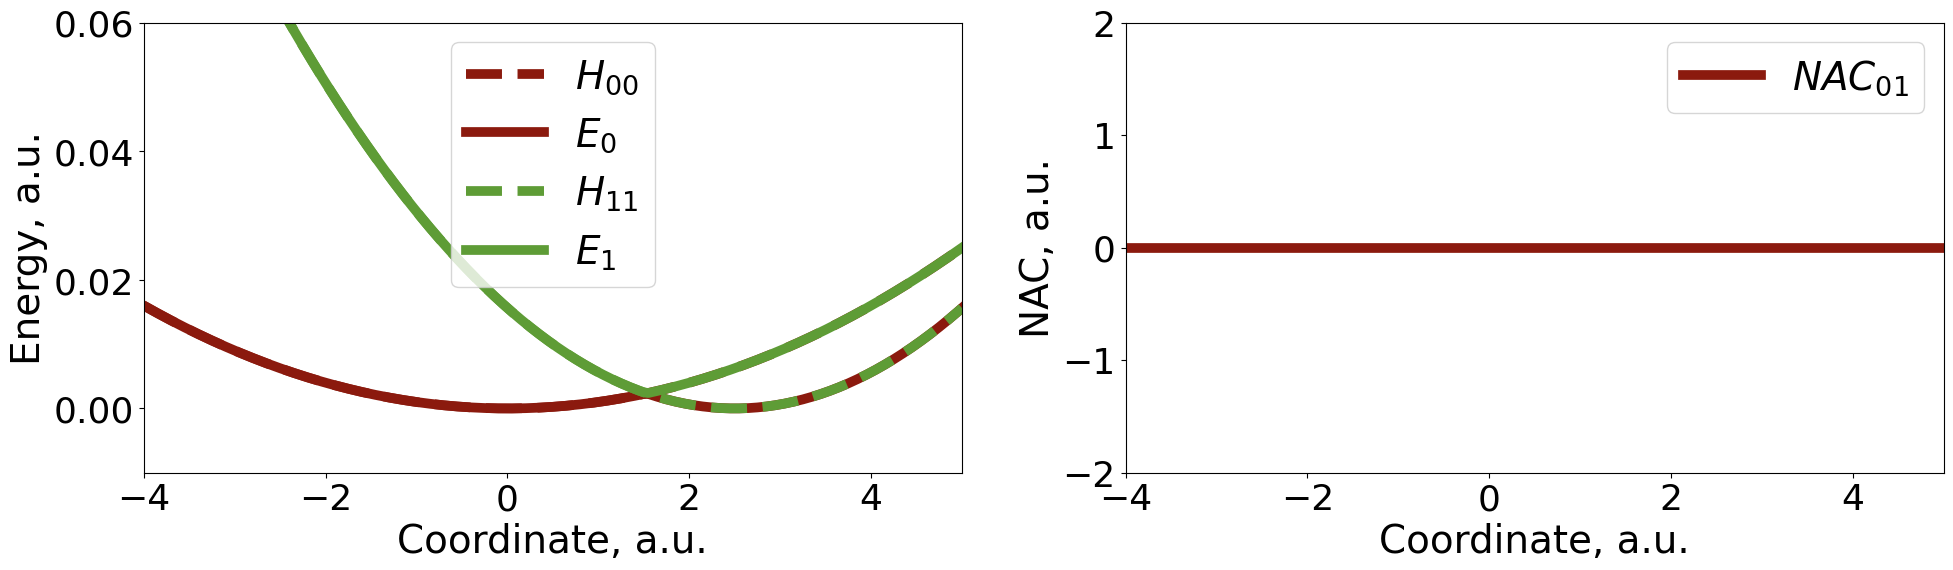

In [5]:
# Model 1
plot_params.update( { "xlim":[-4, 5], "ylim":[-0.01, 0.06], "ylim2":[-2, 2], "show_nac_abs":0 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params1 ], [0, 1], -4.0, 5.0, 0.05, plot_params)

The next model, **Model 2** adds a non-zero and rather small diabatic coupling, so that the surfaces do interact, but the splitting between the adiabatic surfaces is small, hence large NAC 
<a name="plot_surfaces-2"></a>

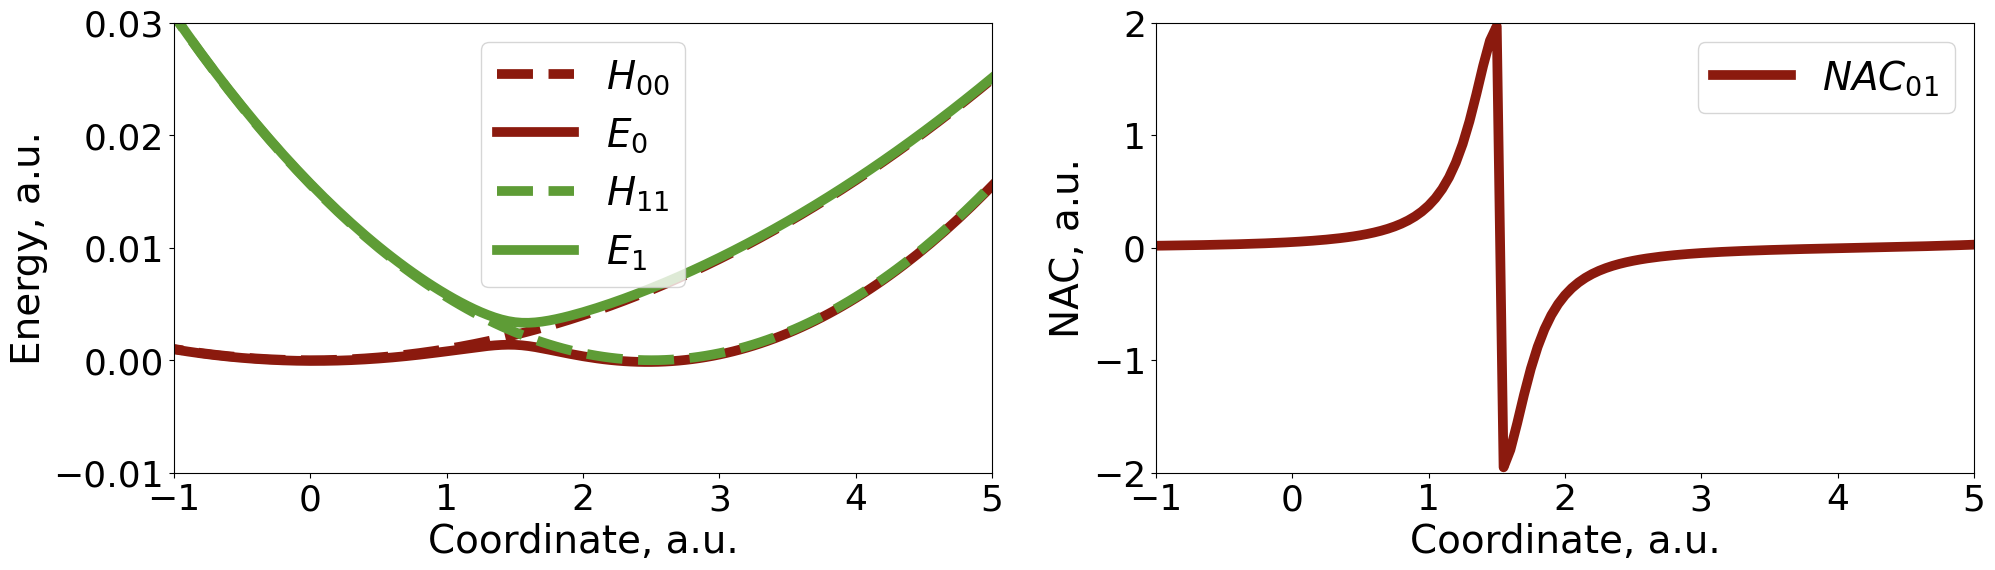

In [6]:
# Model 2
plot_params.update( { "xlim":[-1, 5], "ylim":[-0.01, 0.03], "ylim2":[-2, 2], "show_nac_abs":0 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params2 ], [0, 1], -4.0, 5.0, 0.05, plot_params)

Note that the NACs as computed have the sign flipped when coordinate passes the crossing point. This is because the order of the adiabatic states is switched in this scan (we don't track how the surfaces should actually follow in a continuous way). The correct way the NACs should appear is the Lorentzian shape. To show it, we can simply show the absolute values of NACs. This can be done with the following setup:

`show_nac_abs:1` - this also adds plotting of NAC absolute values (green dash) on top of the NAC values (red solid lines)
<a name="plot_surfaces-3"></a>

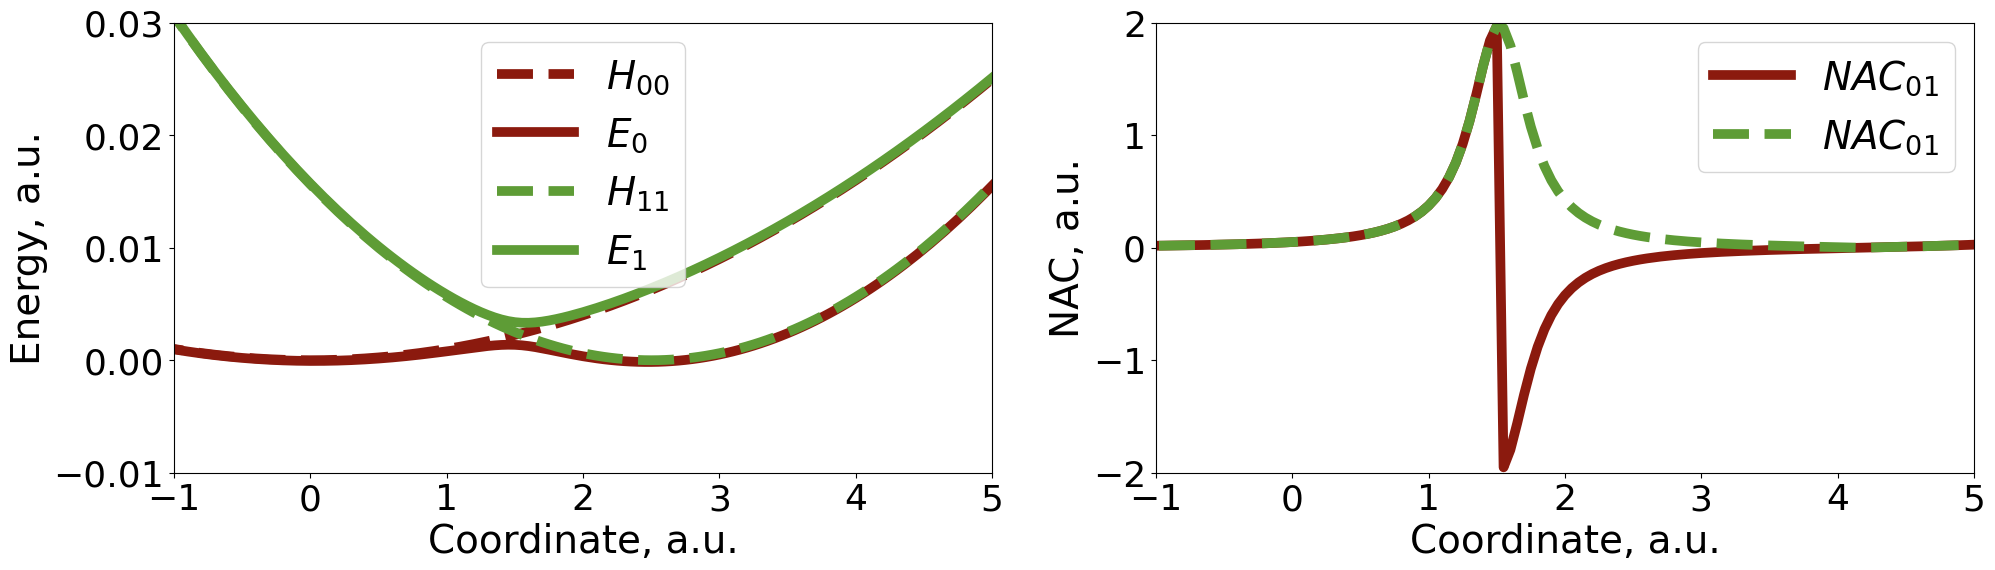

In [7]:
# Special plot for discussion of the NAC sign change
plot_params.update( { "xlim":[-1, 5], "ylim":[-0.01, 0.03], "ylim2":[-2, 2], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params2 ], [0, 1], -4.0, 5.0, 0.05, plot_params)


In the next model, **Model 3**, we use even larger diabatic coupling, so that the adiabatic surfaces have a large gap between them. In this case, the NACs are small, so the nonadiabatic effects are rather low - this is a model for primarily adiabatic dynamics.
<a name="plot_surfaces-4"></a>

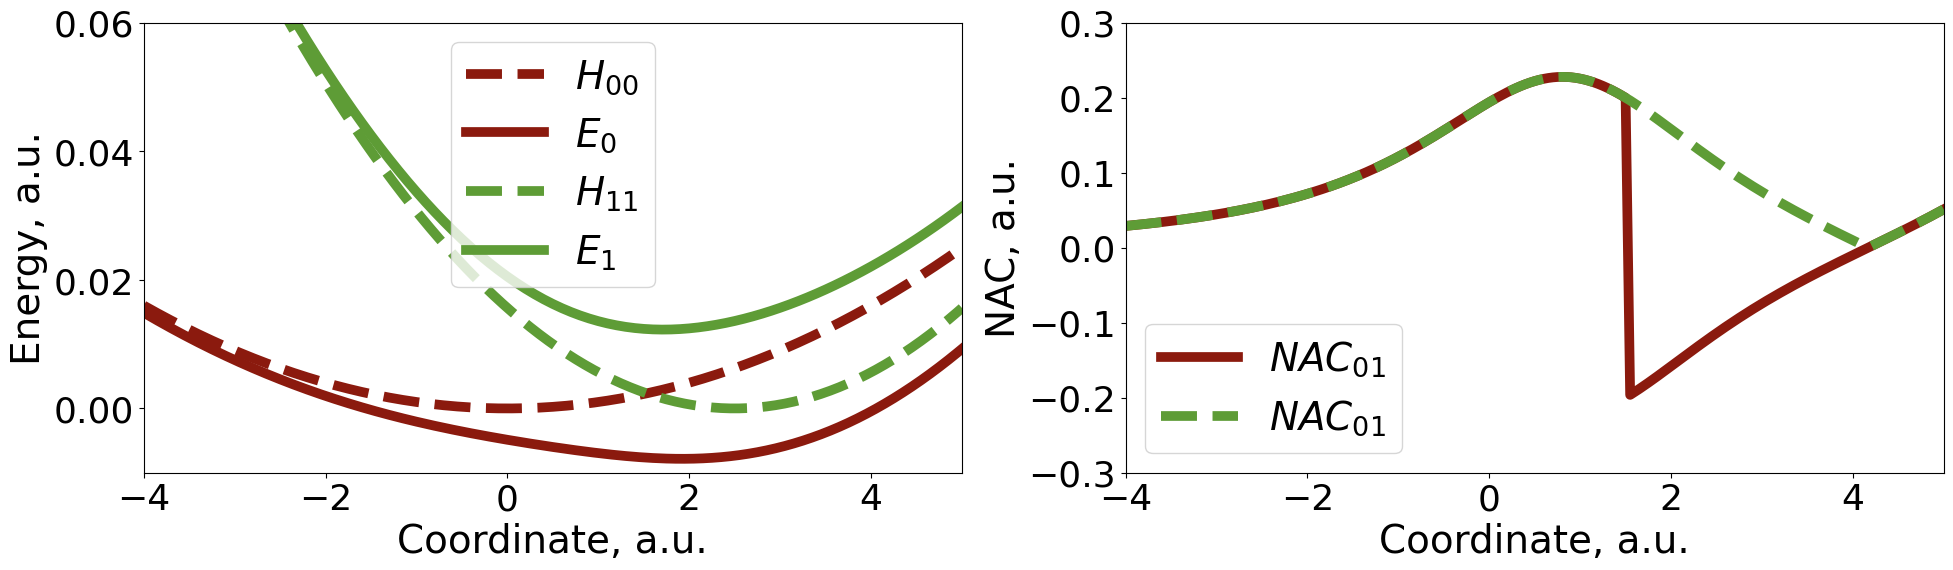

In [8]:
# Model 3
plot_params.update( { "xlim":[-4, 5], "ylim":[-0.01, 0.06], "ylim2":[-0.3, 0.3],"show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params3 ], [0, 1], -4.0, 5.0, 0.05, plot_params)

Finally, the **Model 4** is a more compicated case of Model 2. The parabolas are shifted and their curvatures are chosen such that we have two crossing regions. Then, we have the two regions of strong nonadiabatic coupling

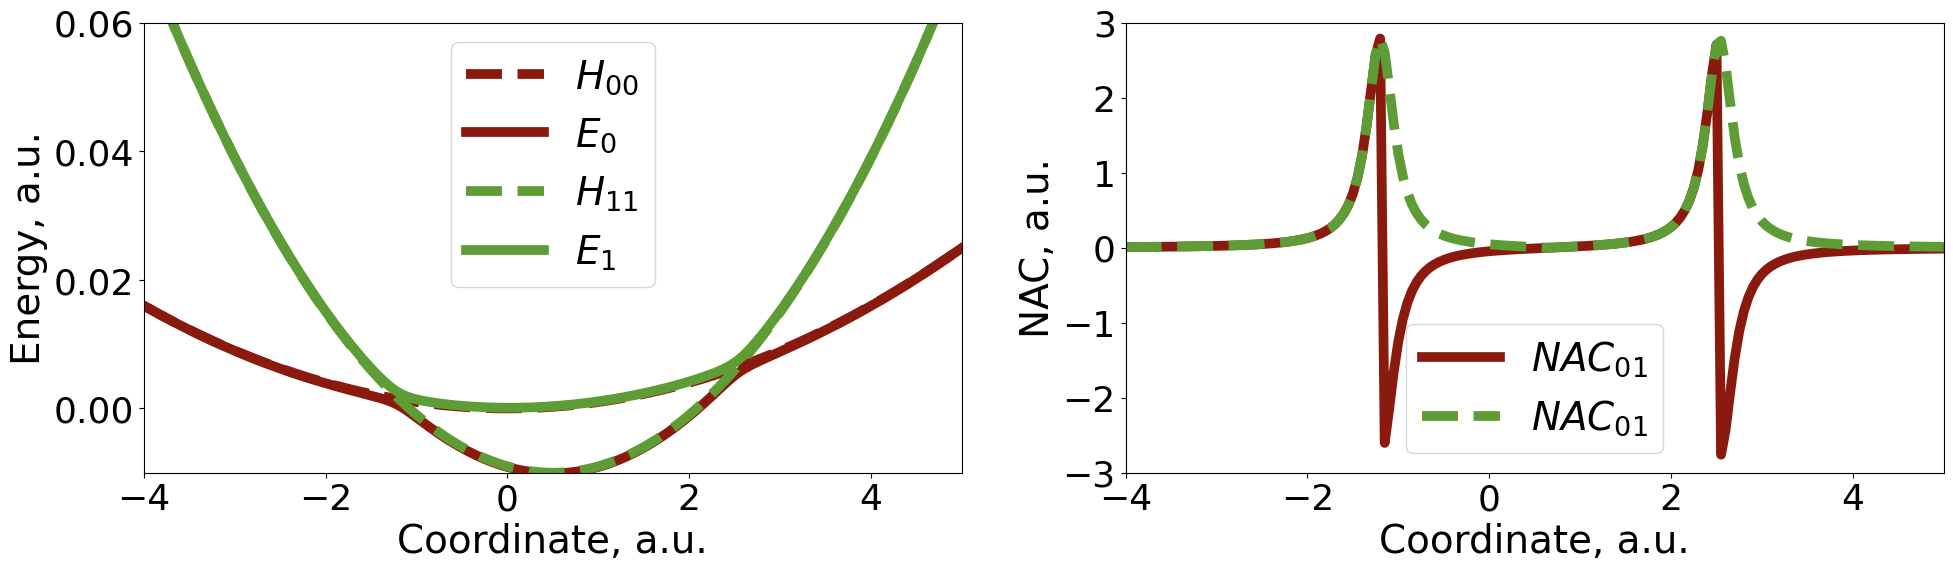

In [9]:
# Model 4
plot_params.update( { "xlim":[-4, 5], "ylim":[-0.01, 0.06], "ylim2":[-3, 3], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params4 ], [0, 1], -4.0, 5.0, 0.05, plot_params)

**Model 5** is a simple crossing of two lines (diabatic surfaces). The diabatic coupling is a constant. This model nearly corresponds to the curve crossing considered in Landau-Zener theories, although remember that the energies in LZ problems are the linear functions of time, rather than coordinate. However, it is possible to imagine coordinate changing linearly with time (constant velocity), in which case the two types of models would be strongly related to each other.

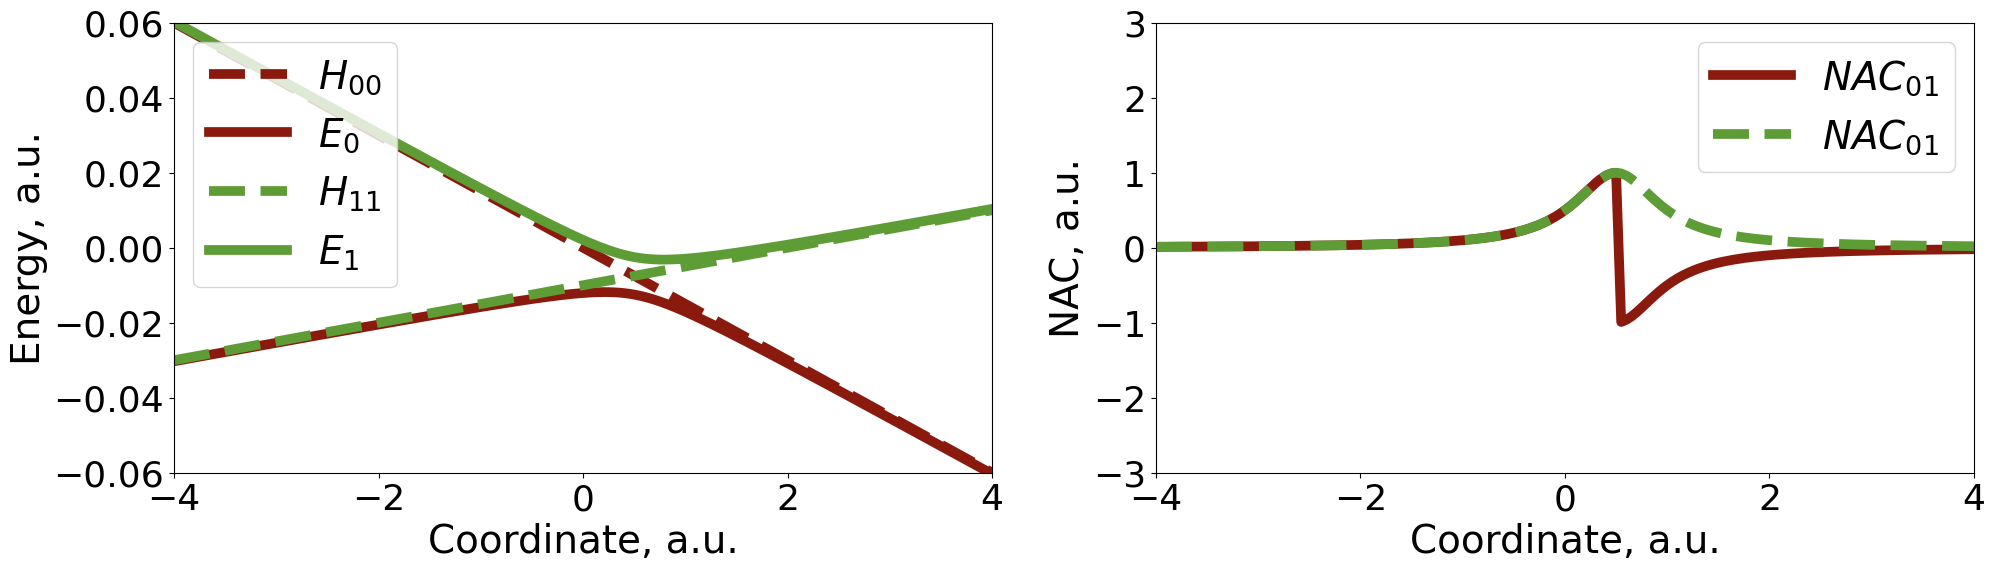

In [10]:
# Model 5
plot_params.update( { "xlim":[-4, 4], "ylim":[-0.06, 0.06], "ylim2":[-3, 3], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params5 ], [0, 1], -4.0, 4.0, 0.05, plot_params)

In the next **Model6**, we consider a somewhat more interesting situation - one curve crosses two parallel diabatic surfaces, leading to two parallel adiabatic surfaces. This model is a good test case for decoherence theories. In principle, the wavepackets moving on two parallel surfaces with the same initial momenta should lead to a non-vanishing coherence among them. Such coherences are usually destroyed by the TSH methods that select only one surface at a time. So, this is an interesting model to apply the NAMD methods to. 

However, keep in mind that the two wavepackets would really need to have identical momenta and widths to exhibit a non-vanishing coherence. If the wavepackets are created by splitting the initial one (e.g. incoming from the crossing surface), the chances are that the wavepackets populated on the two parallel surfaces would still have different momenta and/or widths. In this scenario the are expected to decohere still.

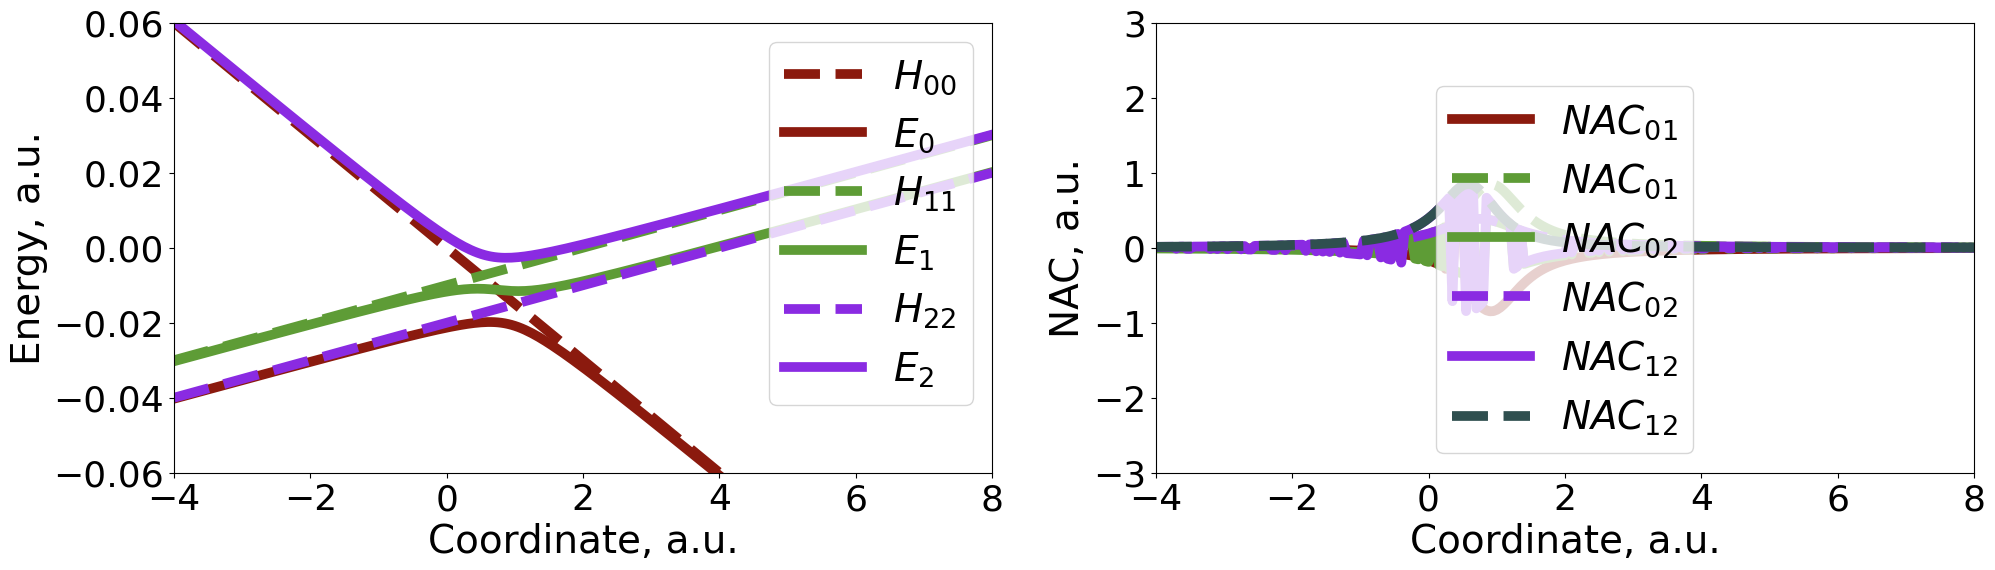

In [11]:
# Model 6
plot_params.update( { "xlim":[-4, 8], "ylim":[-0.06, 0.06], "ylim2":[-3, 3], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params6 ], [0, 1, 2], -4.0, 8.0, 0.05, plot_params)

**Model 7** extends model 6 to the case of 4 parallel surfaces. They all are equidistant to nearest-neightbos surface, in this case.

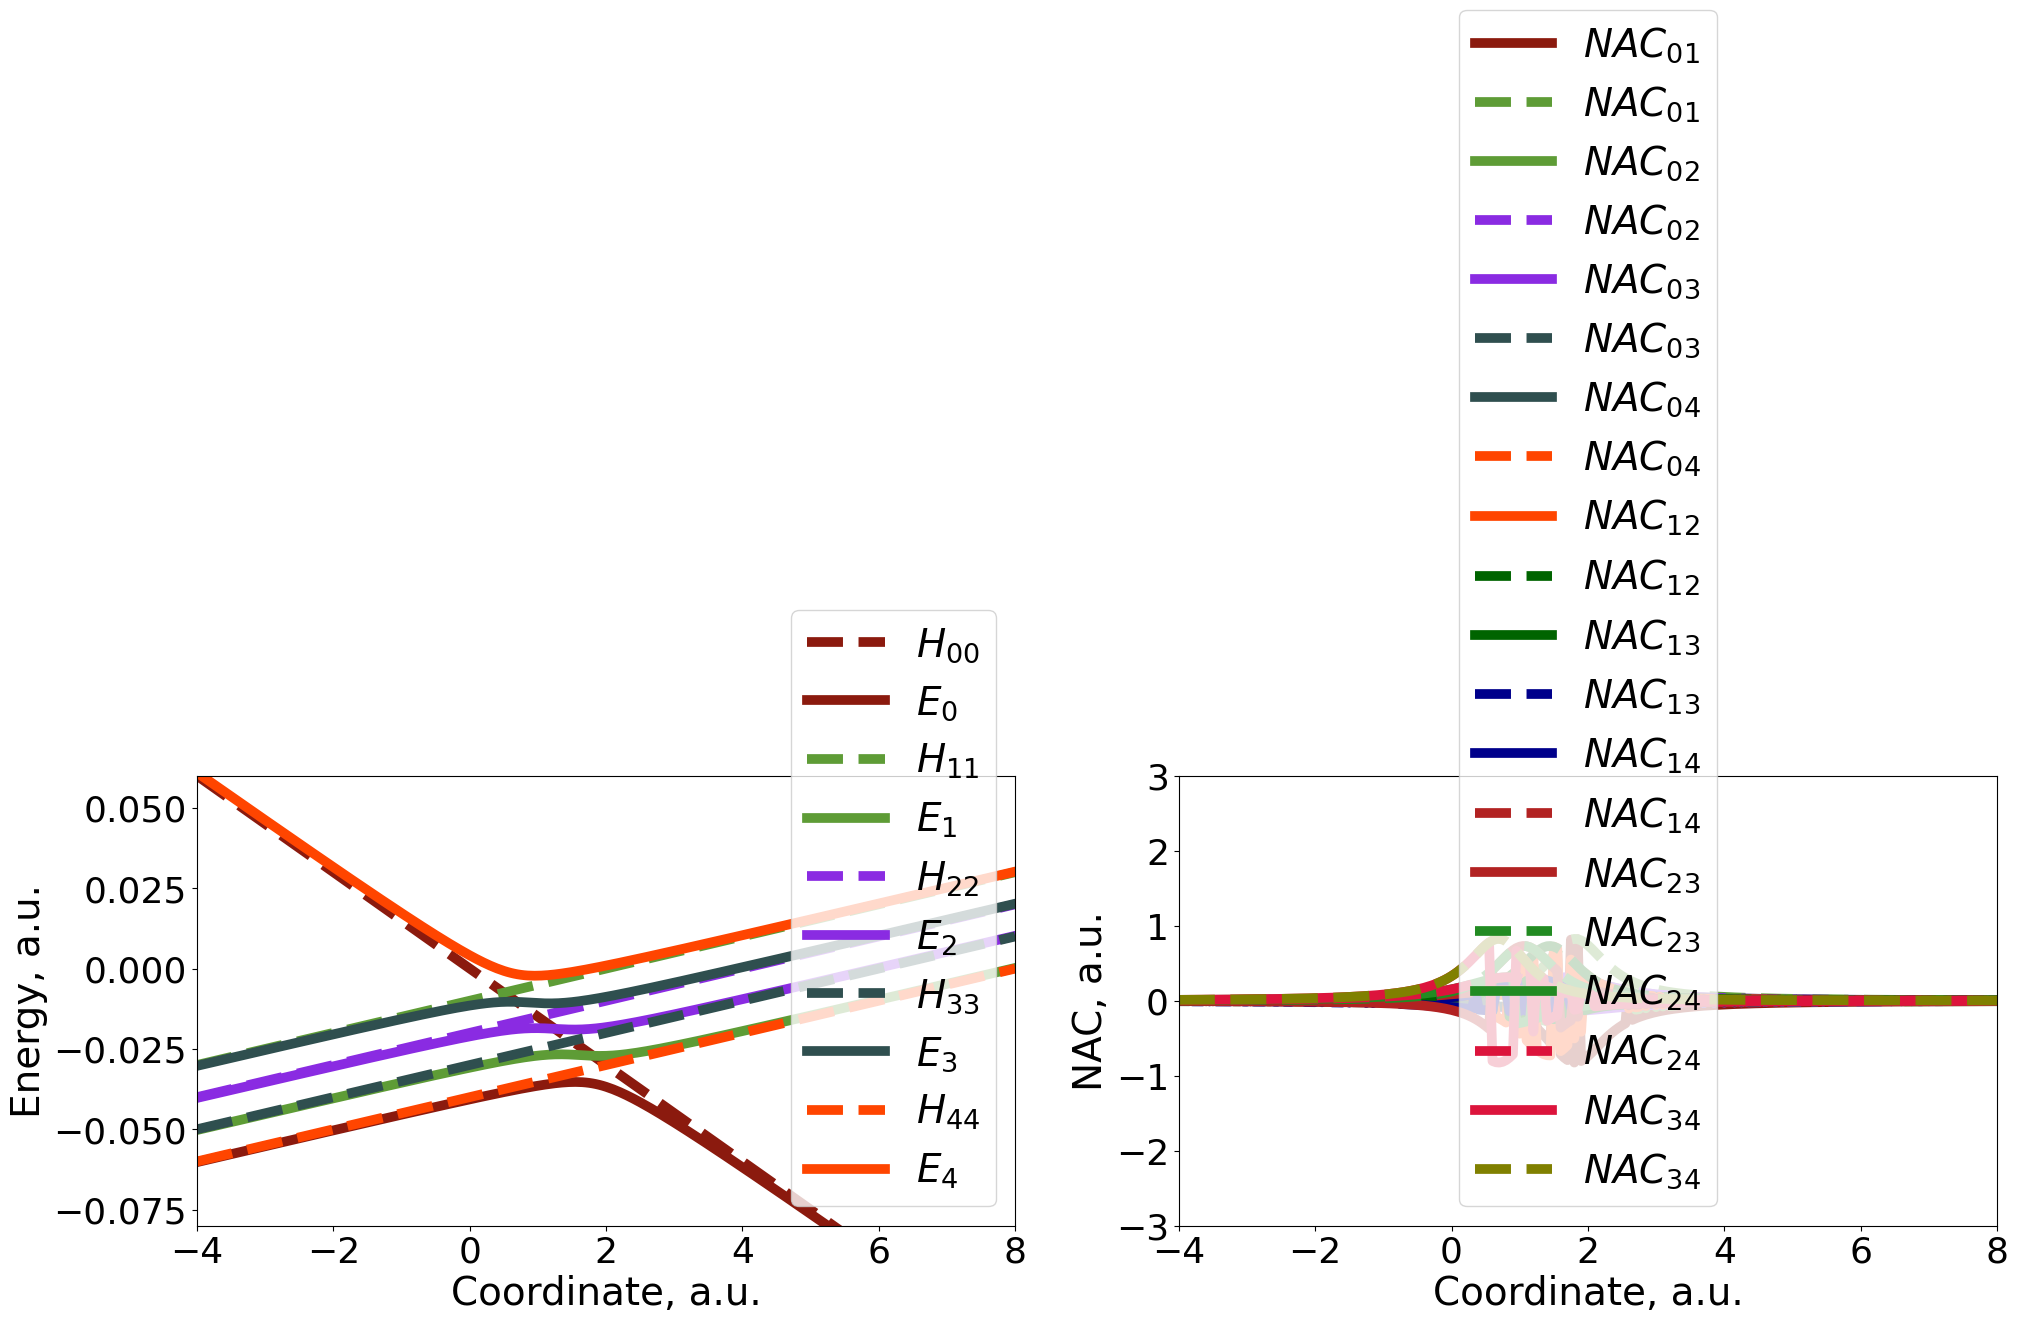

In [12]:
# Model 7
plot_params.update( { "xlim":[-4, 8], "ylim":[-0.08, 0.06], "ylim2":[-3, 3], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params7 ], [0, 1, 2, 3, 4], -4.0, 8.0, 0.05, plot_params)

**Model 8** is just like Model 7, but the four parallel surfaces are split into two groups. 

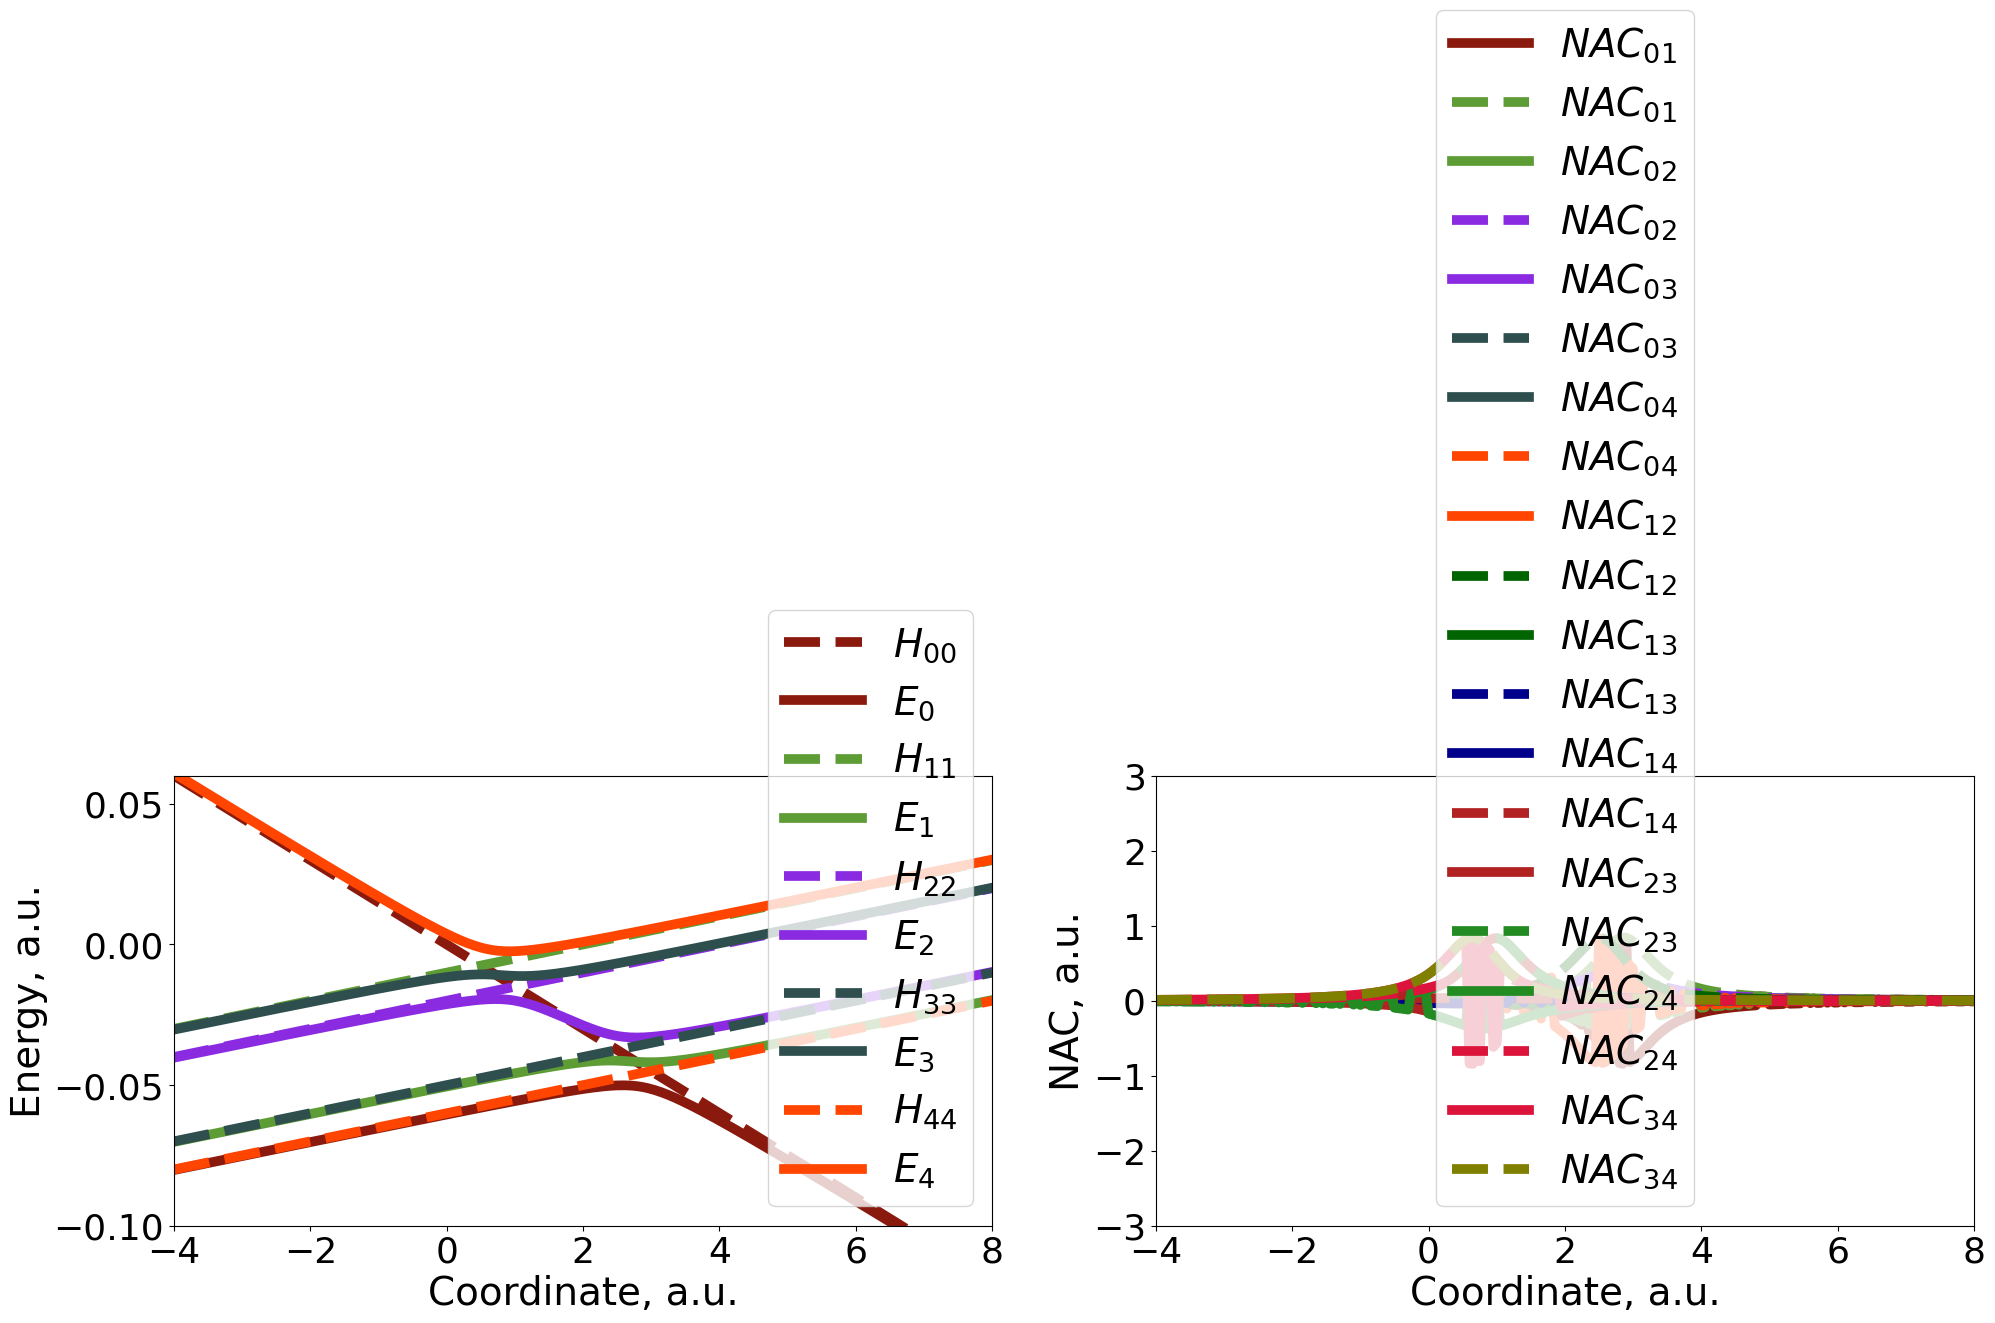

In [13]:
# Model 8
plot_params.update( { "xlim":[-4, 8], "ylim":[-0.10, 0.06], "ylim2":[-3, 3], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params8 ], [0, 1, 2, 3, 4], -4.0, 8.0, 0.05, plot_params)

Finally, **Model 9**, **Model 10**, and **Model 11** represent models of molecular electronic surfaces, as described by Corondao, E. A.; Xing, J.; Miller, W. H. *Chem. Phys. Lett.* **2001**, 349, 521-529

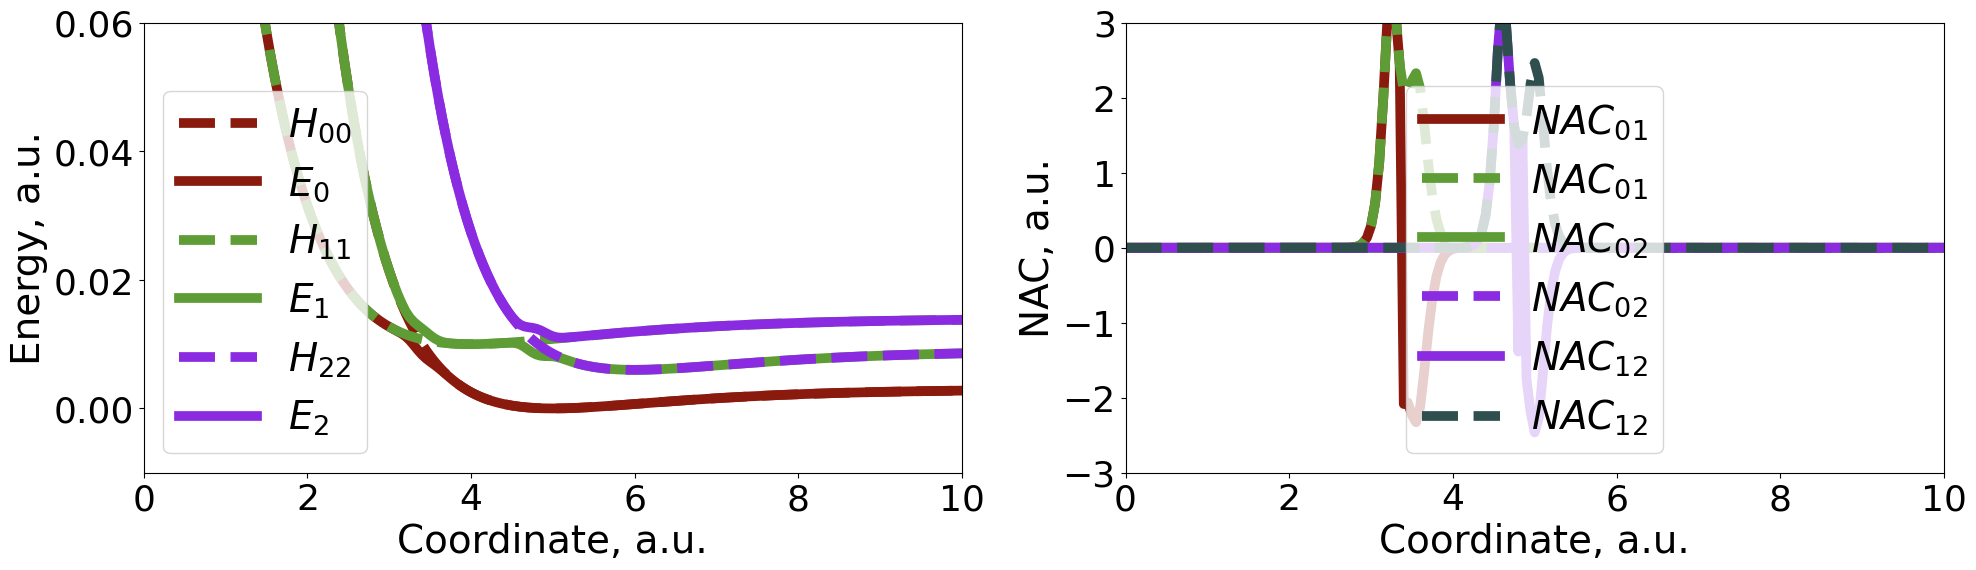

In [14]:
# Model 9
plot_params.update( { "xlim":[0, 10], "ylim":[-0.01, 0.06], "ylim2":[-3, 3], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params9 ], [0, 1, 2], 0.0, 10.0, 0.05, plot_params)

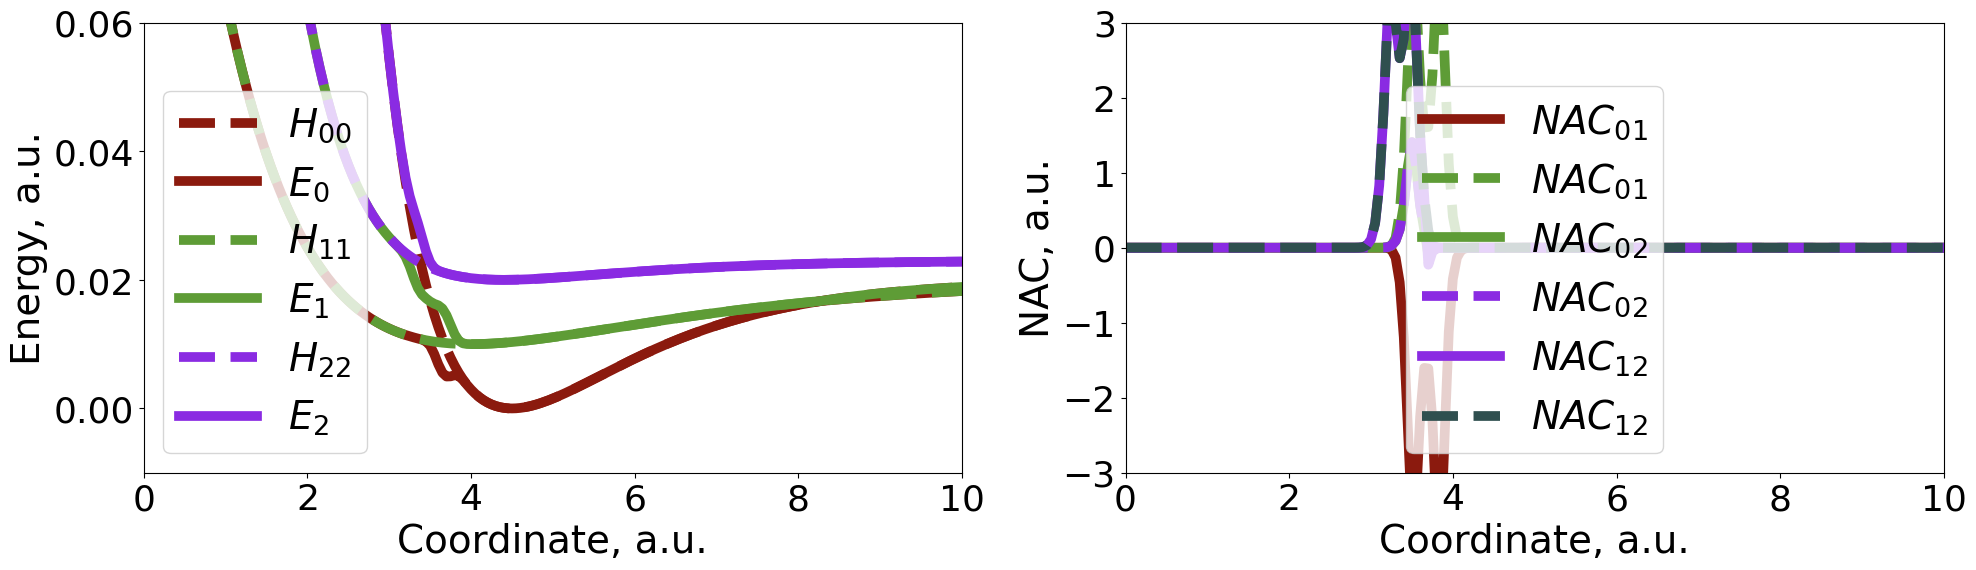

In [15]:
# Model 10
plot_params.update( { "xlim":[0, 10], "ylim":[-0.01, 0.06], "ylim2":[-3, 3], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params10 ], [0, 1, 2], 0.0, 10.0, 0.05, plot_params)

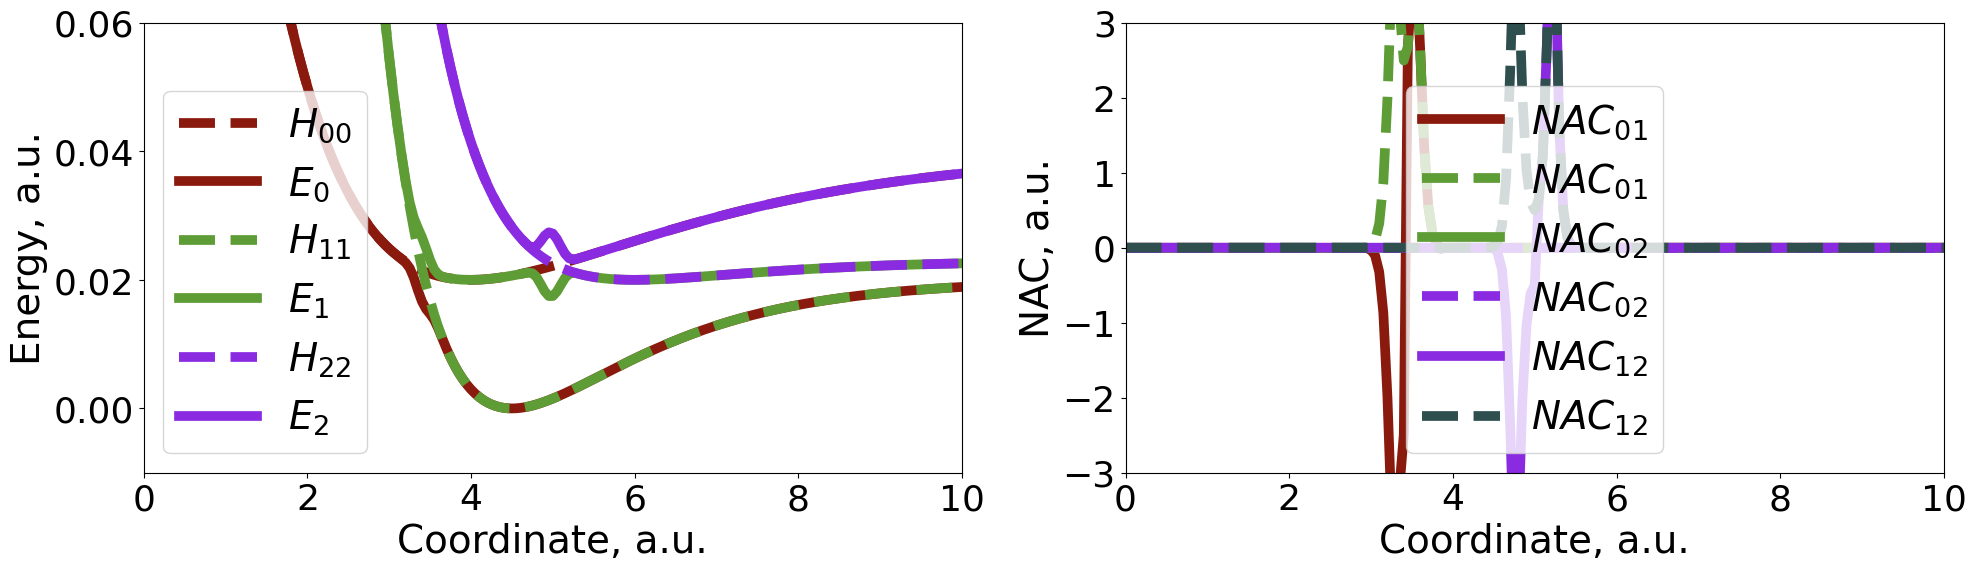

In [16]:
# Model 11
plot_params.update( { "xlim":[0, 10], "ylim":[-0.01, 0.06], "ylim2":[-3, 3], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params11 ], [0, 1, 2], 0.0, 10.0, 0.05, plot_params)

So select the model

In [6]:
# 0 - Holstein, trivial crossing, 2 level
# 1 - Holstein, strong nonadiabatic, 2 level
# 2 - Holstein, adiabatic, 2 level
# 3 - Holstein, double crossing, strong nonadiabatic, 2 level
# 4 - Esch-Levine, LZ-like, 2 level
# 5 - Esch-Levine, 1 crosses 2 parallel, 3 level
# 6 - Esch-Levine, 1 crosses 4 evenly-spaced parallel, 5 level
# 7 - Esch-Levine, 1 crosses 4 parallel split into 2 groups, 5 level
# 8 - Morse 1, 3-level
# 9 - Morse 2, 3-level
# 10 - Morse 3, 3-level

#################################
# Give the model used an index
model_indx = 7
################################

model_params = all_model_params[model_indx]

## 4. Choosing the Nonadiabatic Dynamics Methodology 
<a name="4"></a>[Back to TOC](#TOC)

In this section, we go over parameters to set up a computational methodology. 

Let's start with the simulation-specific parameters:

* `nsteps` -  how many steps of dynamics to compute
* `nstaj` - how many trajectories to use
* `nstates:2` - all our models are 2-level systems
* `dt:10` - nuclear integration timestep in a.u. of time
* `num_electronic_substeps` - do multiple steps of electronic integration per nuclear step
* `isNBRA` and `is_nbra` - is set to `1`, will turn on some simplifications and optimization for NBRA type of calculations. Here, we are doing the non-NBRA case
* `frogress_frequency:0.1` - printing out a message evry `2500 x 0.1 = 250` steps
* `which_adi_states` - properties of which adiabatic states to save, we only have 2
* `which_dia_states` - properties of which diabatic states to save, we only have 2
* `mem_output_level:4` - how much data to save into the hdf5 output files. This is the most intensive output, usually needed only for some special cases (extra-analysis, debugging, new methods, demonstration like htis, etc.)
* `properties_to_save` - list of properties to be computed on the fly and saved into hdf5 output file.

In [7]:
NSTATES = model_params["nstates"]

dyn_general = { "nsteps":2500, "ntraj":25, "nstates":NSTATES,
                "dt":10.0, "num_electronic_substeps":1, "isNBRA":0, "is_nbra":0,
                "progress_frequency":0.1, "which_adi_states":range(NSTATES), "which_dia_states":range(NSTATES),      
                "mem_output_level":3,
                "properties_to_save":[ "timestep", "time", "q", "p", "f", "Cadi", "Cdia", "Epot_ave", "Ekin_ave", "Etot_ave",
                "se_pop_adi", "se_pop_dia", "sh_pop_adi"],
                "prefix":"adiabatic_md", "prefix2":"adiabatic_md"
              }

#[ "timestep", "time", "q", "p", "f", "Cadi", "Cdia", "Epot_ave", "Ekin_ave", "Etot_ave",
#                "se_pop_adi", "se_pop_dia", "sh_pop_adi", "hvib_adi", "hvib_dia", "St", "basis_transform", "D_adi" ]

Now, it is time to select the type of calculations we want to do. Keep in mind that some options are related to each other, so usually one would need to correlate the choices

In [8]:
#################################
# Give the recipe above an index
method_indx = 20
#################################

if method_indx == 0:
    ehrenfest_dia.load(dyn_general)  # Ehrenfest, dia
elif method_indx == 1:
    ehrenfest_adi_nac.load(dyn_general)  # Ehrenfest, adi with NACs    
elif method_indx == 2:
    ehrenfest_adi_ld.load(dyn_general)  # Ehrenfest, adi with LD
elif method_indx == 3:
    mfsd.load(dyn_general)  # MFSD

elif method_indx == 4:
    fssh.load(dyn_general)  # FSSH
elif method_indx == 5:
    fssh_ssy.load(dyn_general)  # FSSH + SSY
elif method_indx == 6:
    gfsh.load(dyn_general)  # GFSH
elif method_indx == 7:
    gfsh_ssy.load(dyn_general)  # GFSH + SSY
elif method_indx == 8:
    mssh.load(dyn_general)  # MSSH
elif method_indx == 9:
    mssh_ssy.load(dyn_general)  # MSSH + SSY    

elif method_indx == 10:
    bcsh.load(dyn_general)  # BCSH    
elif method_indx == 11:
    bcsh_ssy.load(dyn_general)  # BCSH + SSY
elif method_indx == 12:
    sdm.load(dyn_general)  # SDM with default EDC parameters
elif method_indx == 13:
    sdm_ssy.load(dyn_general)  # SDM with default EDC parameters + SSY
elif method_indx == 14:
    ida.load(dyn_general)  # IDA
elif method_indx == 15:
    ida_ssy.load(dyn_general)  # IDA + SSY
elif method_indx == 16:
    dish.load(dyn_general)  # DISH with default EDC parameters 
elif method_indx == 17:
    dish.load(dyn_general)  # DISH with IPSD decoherence rates
    dyn_general.update({"decoherence_times_type":3}) # Schwartz 2 decoherence times
elif method_indx == 18:
    sdm.load(dyn_general)  # SDM with IPSD decoherence rates
    dyn_general.update({"decoherence_times_type":3}) # Schwartz 2 decoherence times
elif method_indx == 19:
    sdm_ssy.load(dyn_general)  # SDM with IPSD decoherence rates + SSY
    dyn_general.update({"decoherence_times_type":3}) # Schwartz 2 decoherence times
elif method_indx == 20:
    shxf.load(dyn_general)  # SHXF
    
# This needs to be set up here, but since we are going to consider different sets of such parameters,
# we will comment this section here and re-define it below
#if method_indx in [3, 17, 18, 19]:
#    A = MATRIX(NSTATES, NSTATES)
#    for i in range(NSTATES):
#        A.set(i,i, 10.0)
#    dyn_general.update({"schwartz_decoherence_inv_alpha":A})    

For the surface hopping methods, we can also choose how to handge frustrated hops and how to rescale momenta on hops

In [9]:
#################################
# Adds ways of hop acceptance/velocity rescaling, only for some methods
# vary this only for methods: [4 - 16]
variant_indx = 0
#################################

if method_indx in [0, 1, 2, 3]:
    variant_indx = 0 # use default settings
else:
    pass

suff = ""
if variant_indx == 0:
    # This is already a default behavior 
    #dyn_general.update({"hop_acceptance_algo":10, "momenta_rescaling_algo":101 }) 
    suff = "v-" # accept and rescale based on total energy, reverse on frustrated    
elif variant_indx == 1:
    dyn_general.update({"hop_acceptance_algo":10, "momenta_rescaling_algo":100 })  
    suff = "v+" # accept and rescale based on total energy, do not reverse on frustrated
elif variant_indx == 2:    
    dyn_general.update({"hop_acceptance_algo":20, "momenta_rescaling_algo":200 })  
    suff = "h-" # accept and rescale based on NAC vectors, do not reverse on frustrated
elif variant_indx == 3:        
    dyn_general.update({"hop_acceptance_algo":20, "momenta_rescaling_algo":201 })  
    suff = "h+" # accept and rescale based on NAC vectors, reverse on frustrated
elif variant_indx == 4:    
    dyn_general.update({"hop_acceptance_algo":21, "momenta_rescaling_algo":200 })  
    suff = "g-" # accept and rescale based on force differences, do not reverse on frustrated
elif variant_indx == 5:
    dyn_general.update({"hop_acceptance_algo":21, "momenta_rescaling_algo":201 })  
    suff = "g+" # accept and rescale based on force differences, reverse on frustrated
    

Also, for the methods that depend on the external parameters, e.g. Schwartz method, SDM, DIST, etc, we may want to try it with different values of the parameter. The parameter for the width of the nuclear wavepacket in SHXF is also set here.

In [10]:
#################################
# Adds variations of the parameter
param_indx = 1
#################################

if method_indx in [3, 17, 18, 19]:
    if param_indx == 0:
        val = 0.1
    elif param_indx == 1:
        val = 1.0
    elif param_indx == 2:
        val = 10.0 
    elif param_indx == 3:
        val = 100.0
    
    A = MATRIX(NSTATES, NSTATES)
    for i in range(NSTATES):
        A.set(i,i, val)
    dyn_general.update({"schwartz_decoherence_inv_alpha":A})
elif method_indx in [20]:
    param_indx = 0
    dyn_general.update({"wp_width": 0.3})
else:
    param_indx = 0

## 5. Choosing initial conditions: Nuclear and Electronic
<a name="5"></a>[Back to TOC](#TOC)

The setup of the parameters below is rather intuitive:

* `ndof` - number of nuclear degrees of freedom
* `q` - nuclear coordinates, should be of length `ndof`
* `p` - nuclear momenta, should be of length `ndof`
* `mass` - nuclear masses, should be of length `ndof`
* `force_constant` - should be of length `ndof`; this is the force constant of the harmonic potential that defines the width of the Gaussian wavepacket (that is the ground-state solution for such potential)
* `init_type` - how to sample (or not) momenta and coordinates

For electronic variables:
* `ndia` - the number of diabatic states
* `nadi` - the number of adiabatic states
* `rep` - representation in which we initialize the electronic variables:
  - 0 - diabatic wfc;
  - 1 - adiabatic wfc;
  - 2 - diabatic density matrix;
  - 3 - adiabatic density matrix;
* `istates` - the populations of all `rep` states, should be of length `nadi`
* `init_type` - how to sample amplitudes

In [11]:
#*********************** This is for the initial condition type **************************
#============== How nuclear DOFs are initialized =================
#icond_nucl = 0  # Coords and momenta are set exactly to the given value
#icond_nucl = 1  # Coords are set, momenta are sampled
#icond_nucl = 2  # Coords are sampled, momenta are set
icond_nucl = 3  # Both coords and momenta are sampled

nucl_params = { "ndof":1, "q":[-4.0], "p":[0.0], 
                "mass":[2000.0], "force_constant":[0.01], 
                "init_type":icond_nucl }

#============= How electronic DOFs are initialized ==================
#icond_elec = 2  # amplitudes all have the same phase
icond_elec = 3  # amplitudes gain random phase 

#============= Also select the representation ========================
# rep = 0 # diabatic wfc
rep = 1 # adiabatic wfc

istates = []
for i in range(NSTATES):
    istates.append(0.0)    
    
elec_params = {"verbosity":2, "init_dm_type":0,
               "ndia":NSTATES, "nadi":NSTATES, 
               "rep":rep, "init_type":icond_elec, "istates":istates
              }

#============== This computes the enumerated index of the initial condition =============
icond_type_indx = rep * 8 + (icond_elec-2)*4 + icond_nucl


#******************** This is for specific values in initial conditions *******************
#####################################
# Select a specific initial condition
icond_indx = 0
#####################################    

if model_indx in [0, 1]: # Holstein model
    if icond_indx==0:
        nucl_params["q"] = [-4.0]
        elec_params["istates"][0] = 1.0          
    elif icond_indx==1:
        nucl_params["q"] = [-1.0]
        elec_params["istates"][1] = 1.0 
elif model_indx in [2]: # Holstein model
    if icond_indx==0:
        nucl_params["q"] = [-4.0]
        elec_params["istates"][0] = 1.0          
    elif icond_indx==1:
        nucl_params["q"] = [-2.0]
        elec_params["istates"][1] = 1.0 
elif model_indx in [3]: # Holstein model
    if icond_indx==0:
        nucl_params["q"] = [-4.0]
        elec_params["istates"][0] = 1.0          
    elif icond_indx==1:
        nucl_params["q"] = [-3.0]
        elec_params["istates"][1] = 1.0 
elif model_indx in [4]: # Esch-Levine 2-level
    if icond_indx==0:
        nucl_params["q"] = [-3.0]
        elec_params["istates"][1] = 1.0          
elif model_indx in [5]: # Esch-Levine 3-level
    if icond_indx==0:
        nucl_params["q"] = [-3.0]
        elec_params["istates"][2] = 1.0          
elif model_indx in [6,7]: # Esch-Levine 5-level, two types
    if icond_indx==0:
        nucl_params["q"] = [-3.0]
        elec_params["istates"][4] = 1.0          
elif model_indx in [8,9,10]: # Morse models
    if icond_indx==0:
        nucl_params["q"] = [2.0]
        elec_params["istates"][0] = 1.0    
    

## 6. Running the calculations
<a name="6"></a>[Back to TOC](#TOC)
<a name="generic_recipe-1"></a>

In [12]:
%%time

dyn_params = dict(dyn_general)
dyn_params.update({ "prefix":F"model{model_indx}-method{method_indx}-variant_{suff}-param{param_indx}-icond_type{icond_type_indx}-icond{icond_indx}", 
                    "prefix2":F"model{model_indx}-method{method_indx}-variant_{suff}-param{param_indx}-icond_type{icond_type_indx}-icond{icond_indx}" })

print(F"Computing model{model_indx}-method{method_indx}-variant_{suff}-param{param_indx}-icond_type{icond_type_indx}-icond{icond_indx}")    

rnd = Random()
res = tsh_dynamics.generic_recipe(dyn_params, compute_model, model_params, elec_params, nucl_params, rnd)

Computing model7-method20-variant_v--param0-icond_type15-icond0
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Init

In cctor: lvl = 1 der_lvl = 2
destroy auxiliary trajectories 0
destroy auxiliary trajectories 10
destroy auxiliary trajectories 13
destroy auxiliary trajectories 13
destroy auxiliary trajectories 24
destroy auxiliary trajectories 9
destroy auxiliary trajectories 22
destroy auxiliary trajectories 6
destroy auxiliary trajectories 6
destroy auxiliary trajectories 0
destroy auxiliary trajectories 23
destroy auxiliary trajectories 11
destroy auxiliary trajectories 11
 step= 250
destroy auxiliary trajectories 20
destroy auxiliary trajectories 4
destroy auxiliary trajectories 14
destroy auxiliary trajectories 5
destroy auxiliary trajectories 1
destroy auxiliary trajectories 2
 step= 500
destroy auxiliary trajectories 17
destroy auxiliary trajectories 7
destroy auxiliary trajectories 16
destroy auxiliary trajectories 22
destroy auxiliary trajectories 22
destroy auxiliary trajectories 4
destroy auxiliary trajectories 4
destroy auxiliary trajectories 22
destroy auxiliary trajectories 20
destroy 

## 7. Plotting the results
<a name="7"></a>[Back to TOC](#TOC)
<a name="plot_dynamics-1"></a>

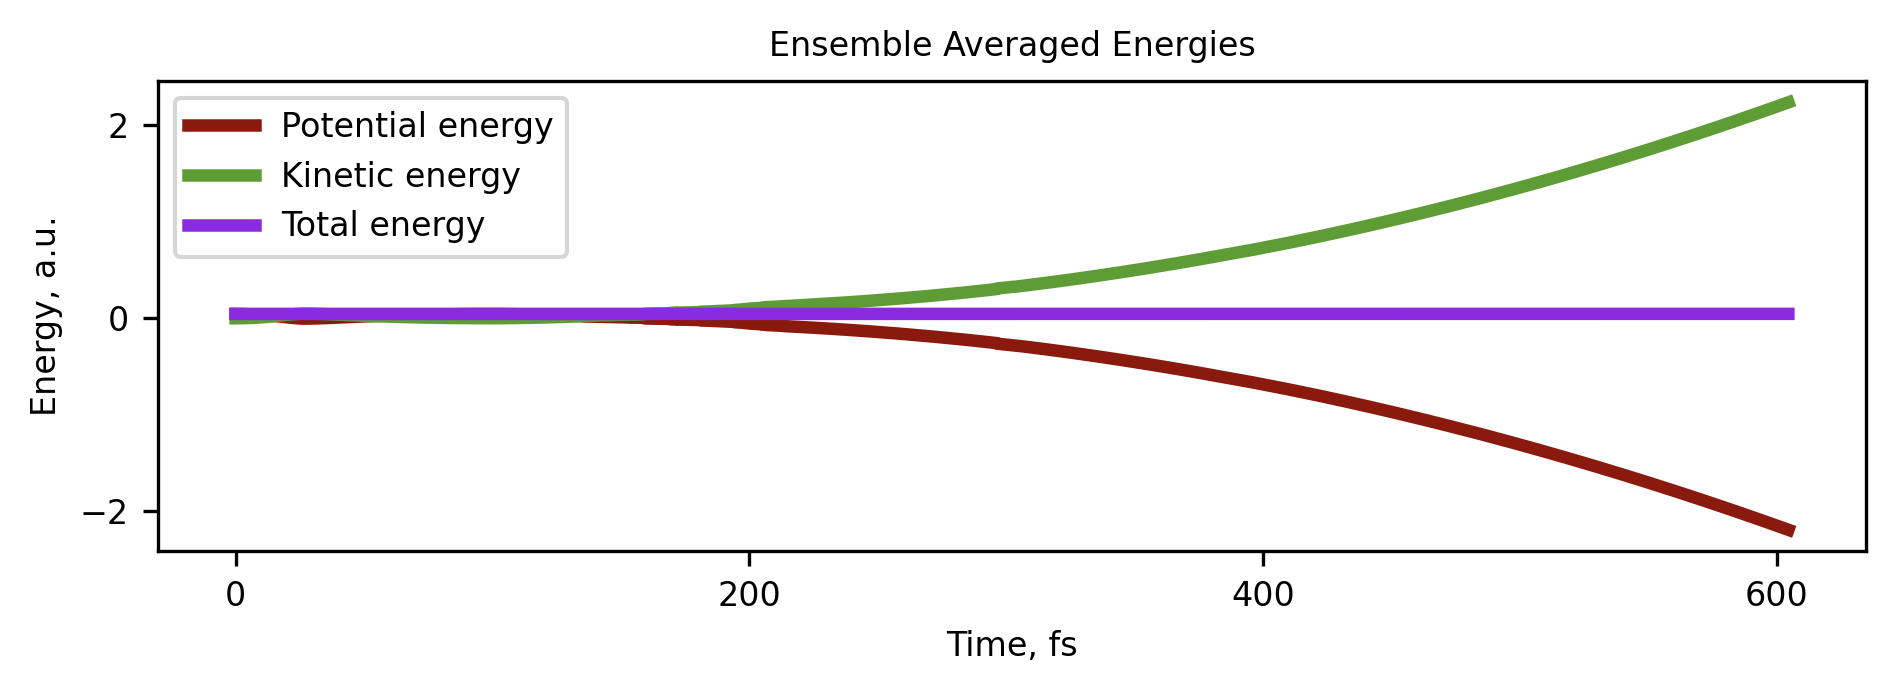

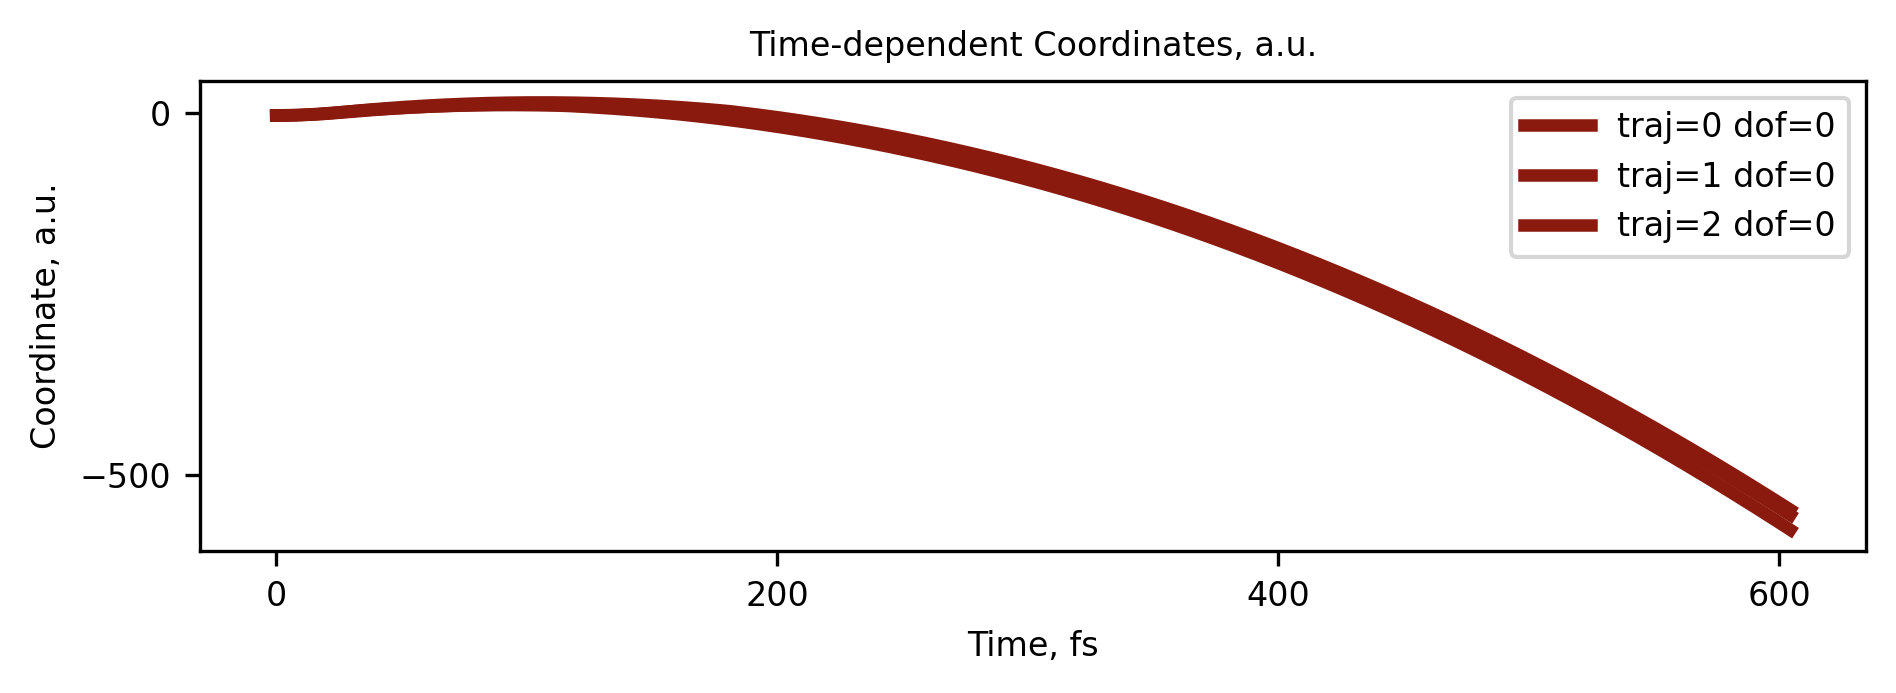

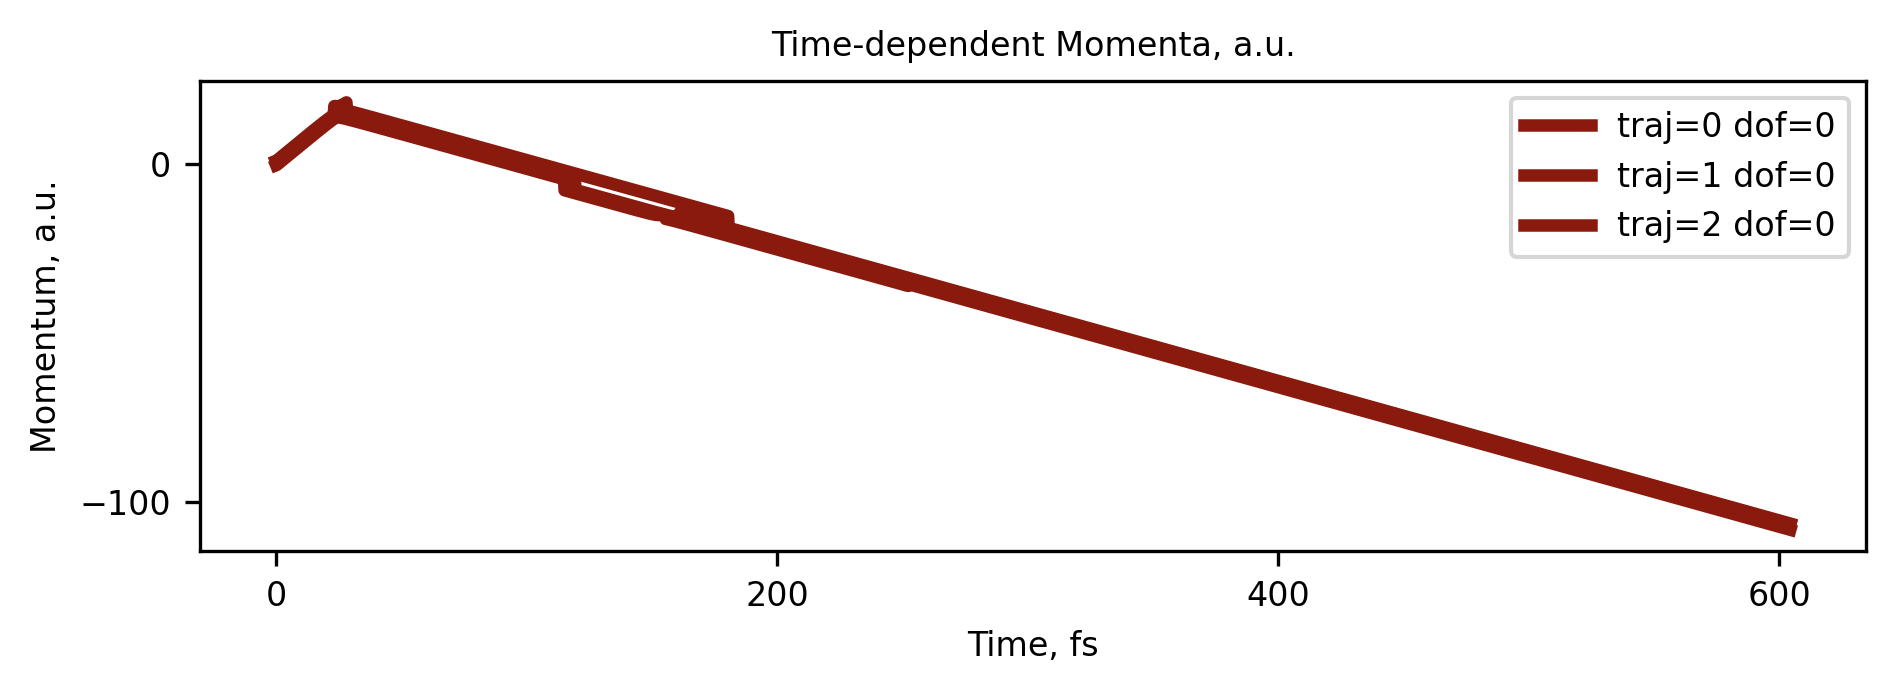

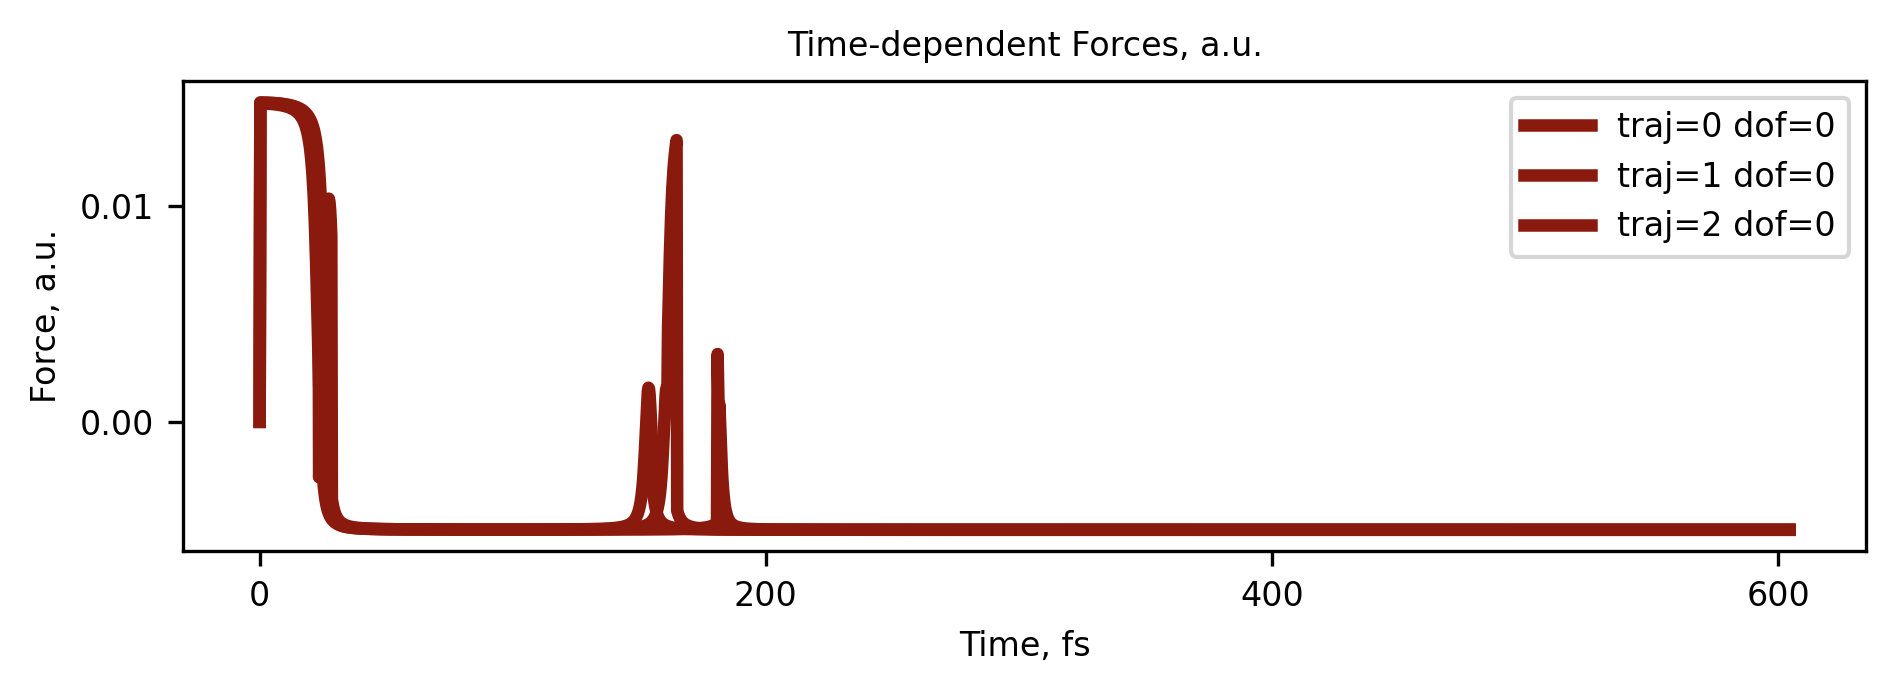

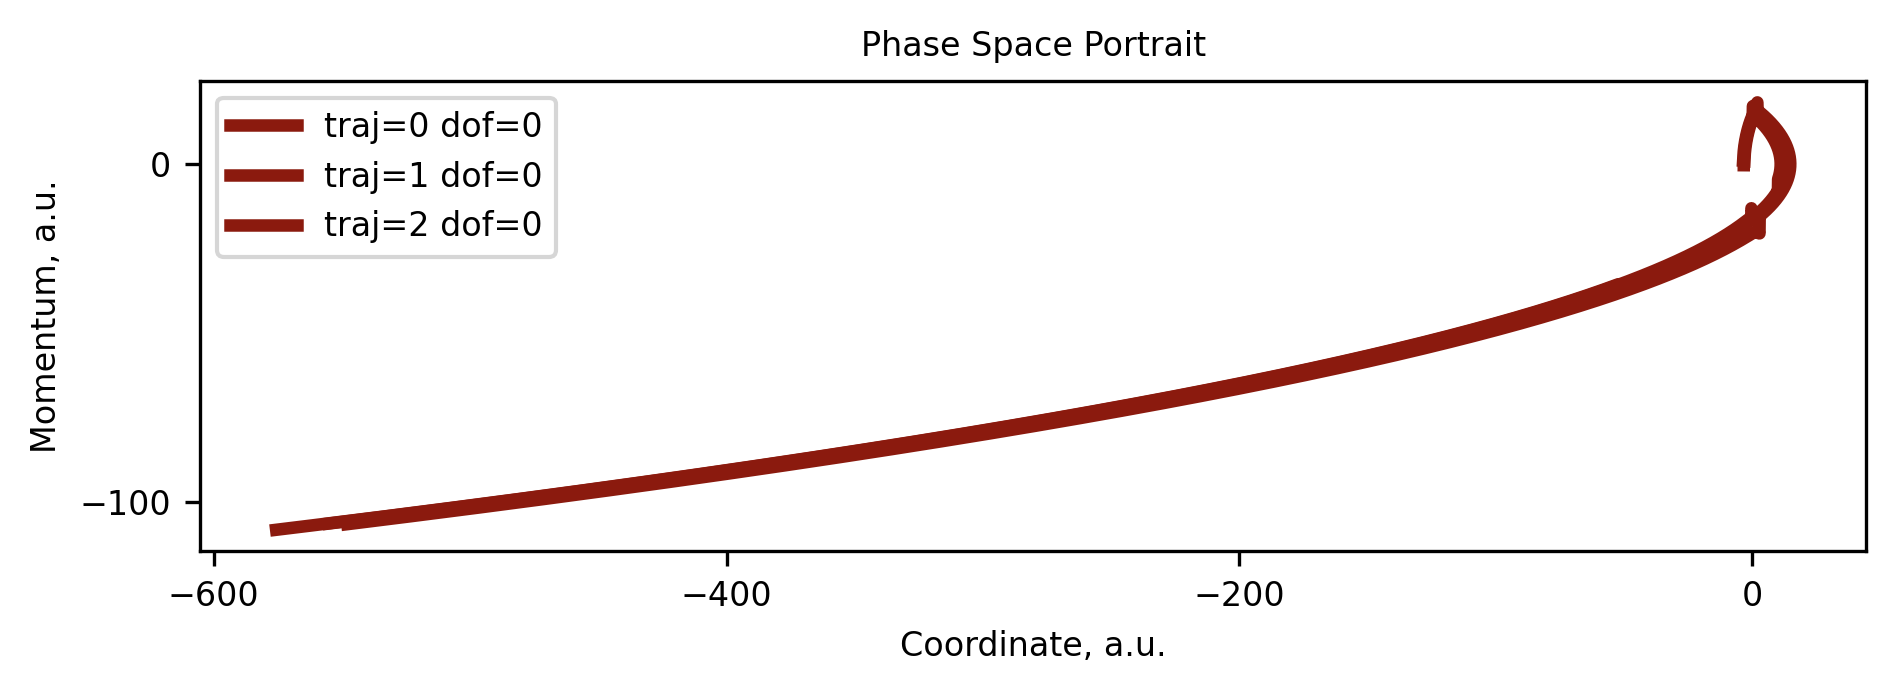

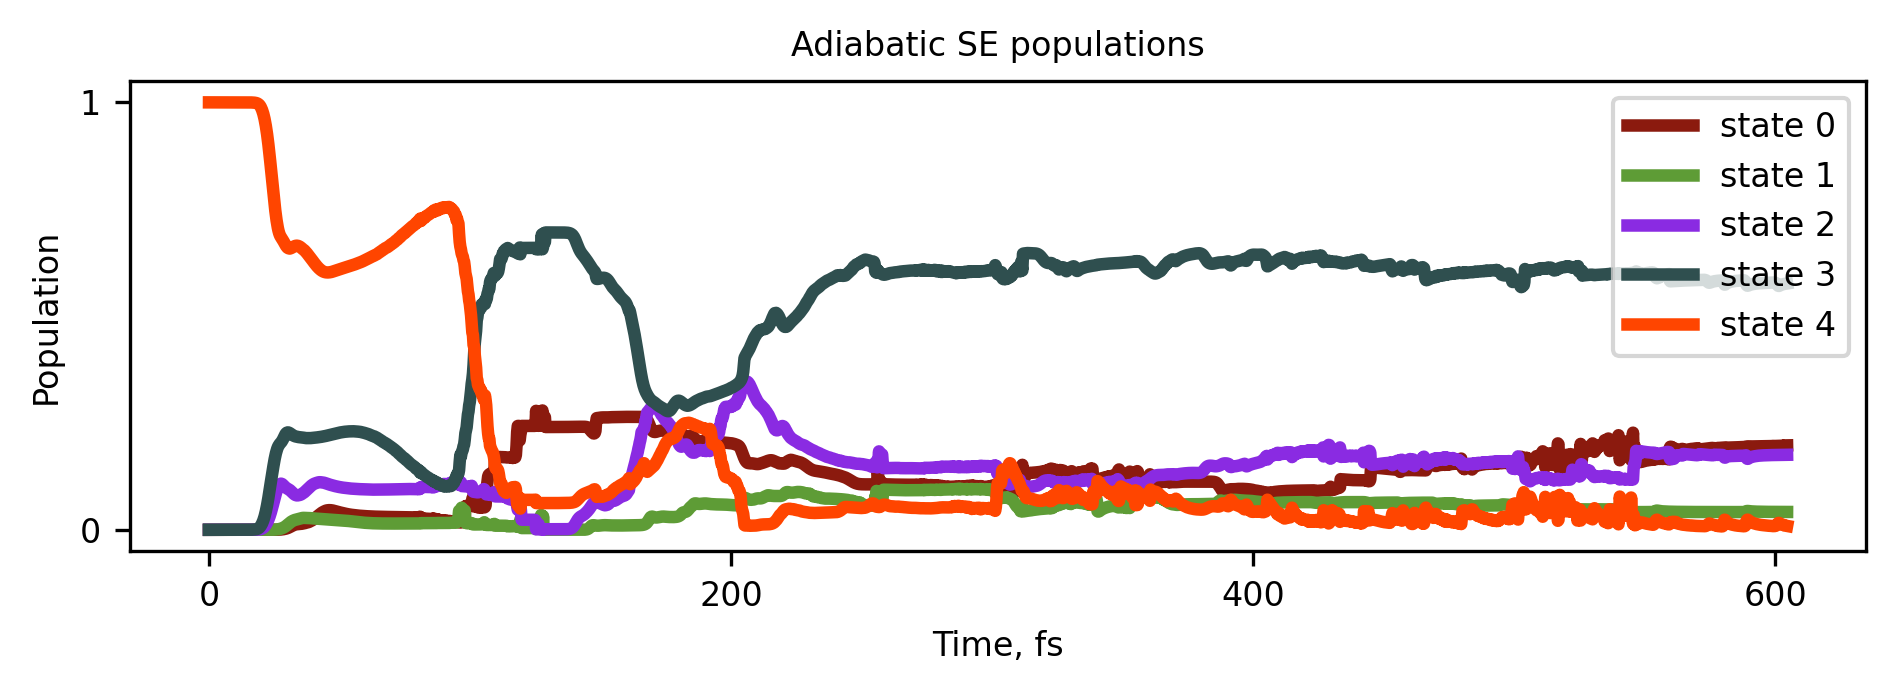

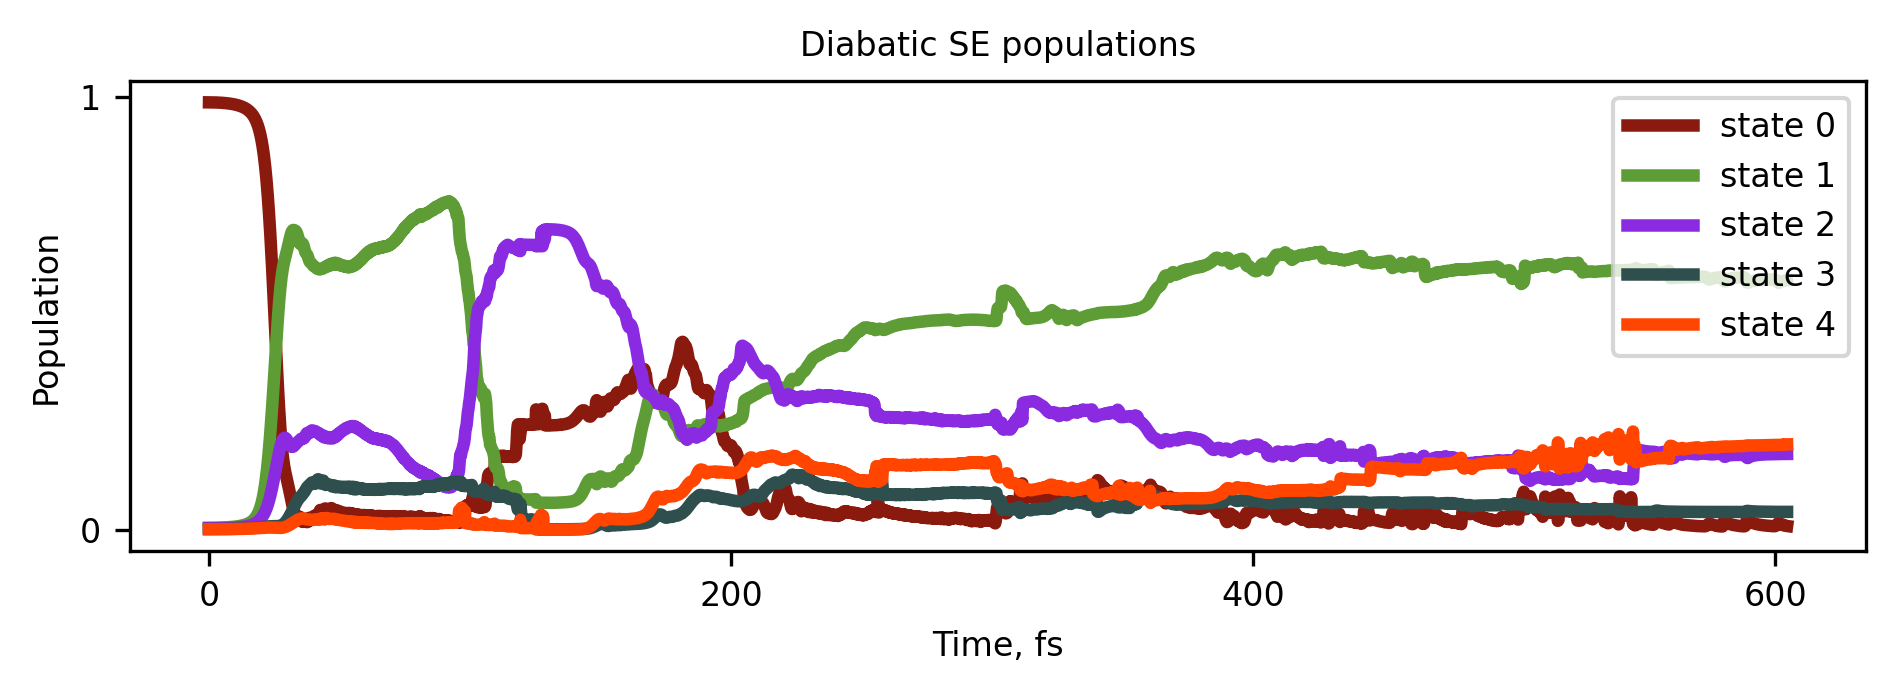

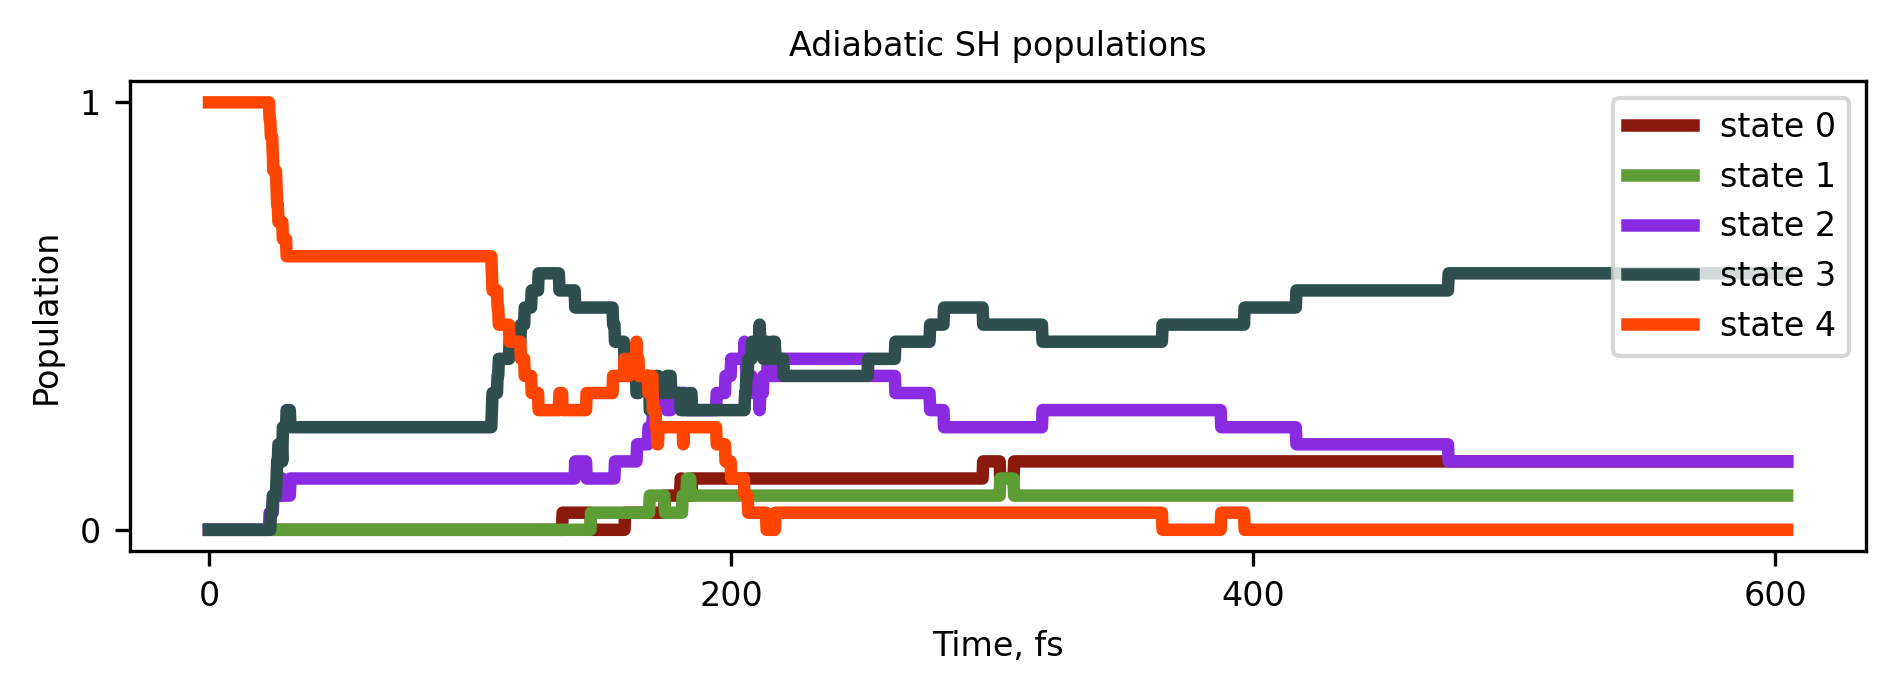

In [13]:
#============ Plotting ==================
pref = F"model{model_indx}-method{method_indx}-variant_{suff}-param{param_indx}-icond_type{icond_type_indx}-icond{icond_indx}"

plot_params = { "prefix":pref, "filename":"mem_data.hdf", "output_level":3,
                "which_trajectories":[0, 1, 2], "which_dofs":[0], "which_adi_states":list(range(NSTATES)), 
                "which_dia_states":list(range(NSTATES)), 
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                "what_to_plot":["coordinates", "momenta",  "forces", "energies", "phase_space", "se_pop_adi",
                                "se_pop_dia", "sh_pop_adi" ], 
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":1, "do_show":1
              }

#"what_to_plot":["coordinates", "momenta",  "forces", "energies", "phase_space", "se_pop_adi",
#                                "se_pop_dia", "sh_pop_adi", "traj_resolved_adiabatic_ham", "traj_resolved_diabatic_ham", 
#                                "time_overlaps", "basis_transform"
#                               ], 

tsh_dynamics_plot.plot_dynamics(plot_params)